### Libraries


In [ ]:
# importing necessary libraries here
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(4)
import warnings
warnings.filterwarnings('ignore')
import pandas as pd


## Environment description

Implementing Temporal Difference Learning algorithms: **SARSA** and **Q-Learning**. Solving several variants of the Grid World problem.

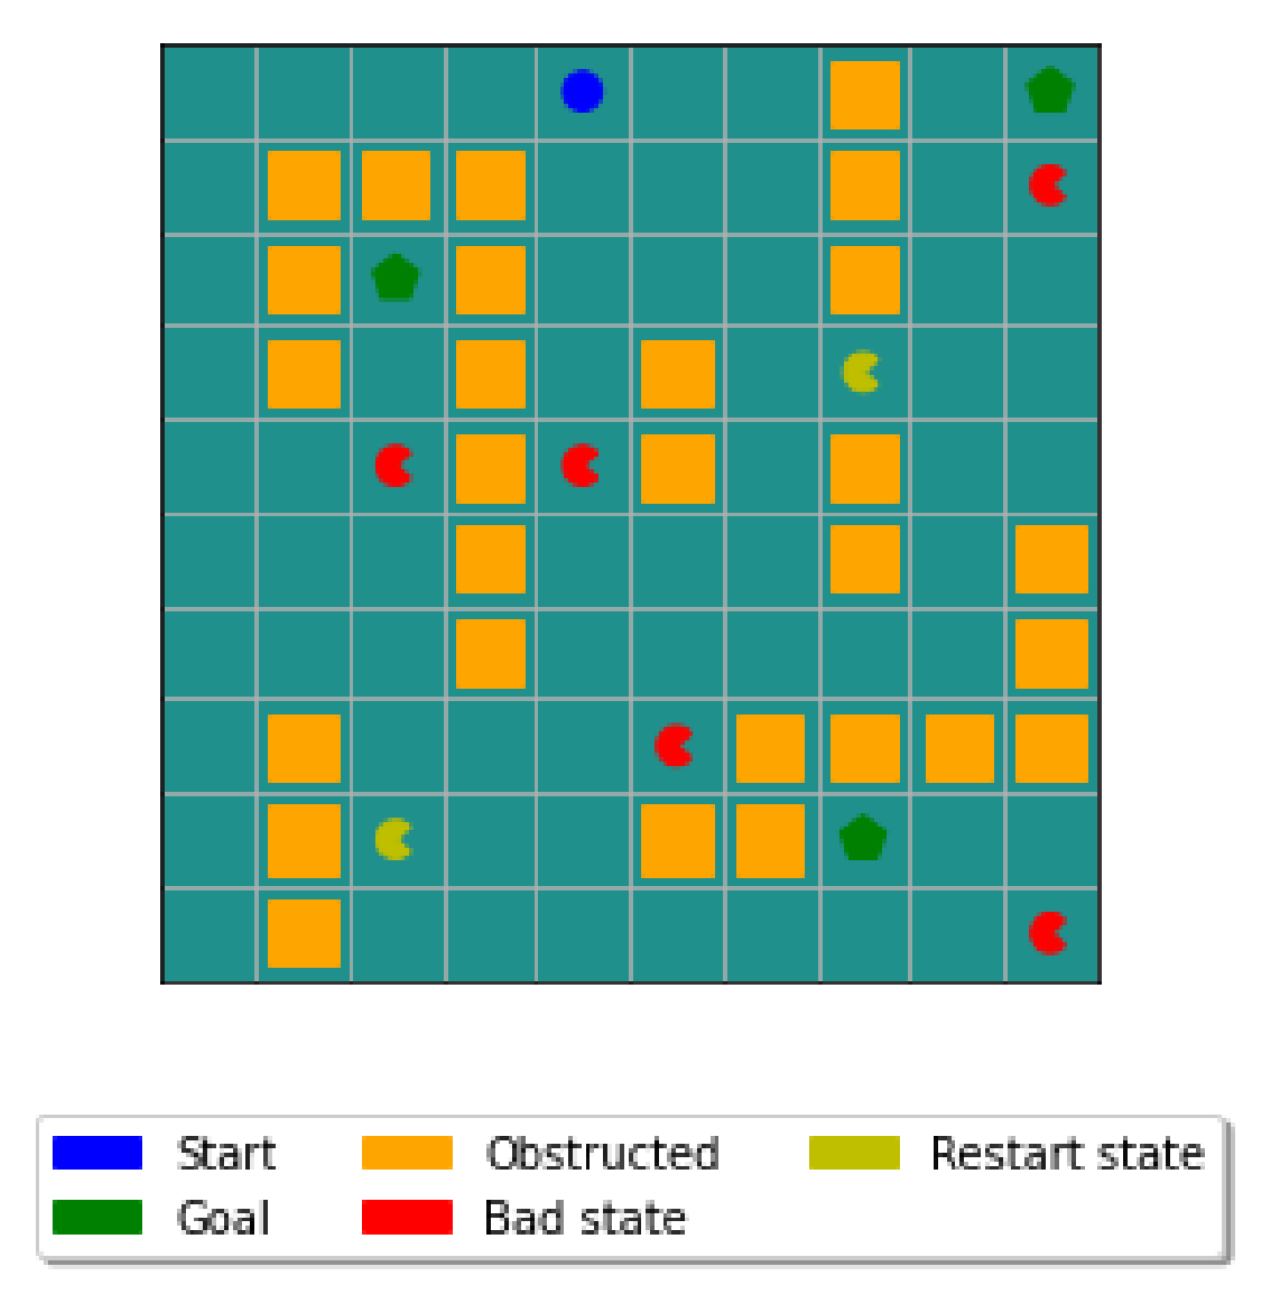

***Figure 1***

The dimensions of the grid are $10 \times 10$. The following types of states exist:

- ***Start state***: The agent starts from this state.
- ***Goal state***: The goal is to reach one of these states. There are 3 goal states in total.

- ***Obstructed state***: These are walls that prevent entry to the respective cells. Transition to these states will not result in any change.

- ***Bad state***: Entry into these states will incur a higher penalty than a normal state.
- ***Restart state***: Entry into these states will incur a very high penalty and will cause agent to teleport to the start state without the episode ending. Once the restart state is reached, no matter what action is chosen, it goes to the start state at the next step.
- ***Normal state***: None of the above. Entry into these states will incur a small penalty.


***Rewards***: -1 for normal states, -100 for restart states, -6 for bad states, +10 for goal states.

## Environment code

The code for the environment can be found below:

In [ ]:
from math import floor
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

#Converts state number to row_column format
def row_col_to_seq(row_col, num_cols = 10):
    return row_col[:,0] * num_cols + row_col[:,1]

#Converts row_column format to state number
def seq_to_col_row(seq, num_cols = 10):
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1
        self.wind = wind

    # mark obstructed cells
    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):

                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1

        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]

    def visualize_gridworld(self):

        # create a 2D grid with empty cells
        grid_world_2D_array = np.ones((self.num_rows, self.num_cols))*ord("E")

        grid_world_2D_array[self.goal_states[:,0],self.goal_states[:,1]]= ord("G")
        grid_world_2D_array[self.obs_states[:,0],self.obs_states[:,1]]= ord("O")
        grid_world_2D_array[self.start_state[:,0],self.start_state[:,1]]= ord("S")
        grid_world_2D_array[self.bad_states[:,0],self.bad_states[:,1]]= ord("B")
        grid_world_2D_array[self.restart_states[:,0],self.restart_states[:,1]]= ord("R")

        grid_world_2D_array_colours = np.ones((self.num_rows, self.num_cols, 3))

        grid_world_2D_array_colours[grid_world_2D_array== ord("G")] =[0,1,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("O")] =[1,0.65,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("S")] =[0,0,1]
        grid_world_2D_array_colours[grid_world_2D_array== ord("B")] =[1,0,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("R")] =[1,1,0]

        fig = px.imshow(grid_world_2D_array_colours)

        state_label = np.empty_like(grid_world_2D_array,
                                    dtype ="<U10")

        state_label[grid_world_2D_array == ord("E")] ="Empty"
        state_label[grid_world_2D_array == ord("G")] ="Goal"
        state_label[grid_world_2D_array == ord("B")] ="Bad"
        state_label[grid_world_2D_array == ord("S")] ="Start"
        state_label[grid_world_2D_array == ord("R")] ="Restart"
        state_label[grid_world_2D_array == ord("O")] ="Obstacle"

        fig.update(data=[{'customdata': state_label,
                          'hovertemplate': 'x: %{x}<br>y: %{y}<br>State: %{customdata}'}])
        # add vertical and horizontal lines
        [fig.add_vline(x=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]
        [fig.add_hline(y=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]

        # ensure each row and column is numbered/labeled
        fig.update_layout(
            title ="Grid World Vizualization <br>Hover over to a cell for information",
            xaxis = dict(
                tickmode='linear',
                side='top',
                dtick=1),
            yaxis = dict(
                tickmode='linear',
                dtick=1)
        )
        fig.show()


## Environment instantiation

In [ ]:
# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[3,6]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = False)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()

## Visualize the grid world

In [ ]:
# visualize the grid world configuration
env.visualize_gridworld()

## List environment variables

In [ ]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


## Tasks
- Implementing SARSA and Q-Learning.
- For SARSA, there are a total of $8$ configurations:
  - set $p = 1$
  - wind could take one of two values, `True` or `False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax
- For Q-learning, there are a total of $8$ configurations:
  - $p = 1$ or $p = 0.7$
  - set `wind = False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax

- For each of the $16$ configurations determining the best set of hyperparameters (i.e. $ϵ$ in $ϵ$-greedy exploration, temperature $\beta$ in softmax exploration, learning rate $\alpha$, and discount factor $\gamma$) which maximize reward per episode over atleast 100 runs. Ploting the following:
  1. Reward curves and the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).
  2. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.
  3. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.
- Trying following set of values for each of the hyperparameters for each of the configurations:

  a. learning rate ($α$) = [0.001, 0.01, 0.1, 1.0]

  b. discount factor ($γ$) = [0.7, 0.8, 0.9, 1.0]

  c. epsilon in $ϵ$-greedy = [0.001, 0.01, 0.05, 0.1] or
  
  Temperature in soft max ($τ$) = [0.01, 0.1, 1, 2]

In [ ]:
# SARSA algorithm implementation
def sarsa(model, alpha, gamma, start_state, start_state_seq, p, is_softmax, wind, epsilon = 0.1, temprature = 0.1, maxiter=100, maxeps=1000, num_agents = 20):
    # Initialize model parameters
    model.start_state_seq = start_state_seq
    model.start_state = start_state
    model.p_good_trans = p
    model.gamma = gamma
    model.wind = wind
    all_Q = []  # List to store Q-values for each agent
    all_rewards = []  # List to store rewards for each agent
    all_steps_to_goal = []  # List to store steps to goal for each agent

    for agent_index in range(num_agents):
        # initialize the state-action value function and the state counts
        Q = np.zeros((model.num_states, model.num_actions))
        state_counts = np.zeros((model.num_states, 1))
        all_Q.append(Q)
        all_rewards.append([])
        all_steps_to_goal.append([])

        # Iterate over episodes
        for i in range(maxeps):

            # for each new episode, start at the given start state
            state = int(model.start_state_seq)
            # Choose initial action using epsilon-greedy or softmax policy
            if is_softmax:
                action = softmax(Q, state, model.num_actions, temprature)
            else:
                action = epsilon_greedy(Q, state, model.num_actions, epsilon)

            episode_reward = 0
            episode_steps_to_goal = 0

            # Iterate over time steps within an episode
            for j in range(maxiter):

                # Sample the next state and reward based on the current state and action
                next_state, reward = model.step(state, action)

                # Choose the next action using epsilon-greedy or softmax policy
                if is_softmax:
                    next_action = softmax(Q, next_state, model.num_actions, temprature)
                else:
                    next_action = epsilon_greedy(Q, next_state, model.num_actions, epsilon)

                # Calculate the temporal difference and update Q function
                Q[state, action] += alpha * (reward + model.gamma * Q[next_state, next_action] - Q[state, action])

                episode_reward += reward
                episode_steps_to_goal +=1

                # count the state visits
                state_counts[state] += 1

                # End episode is state is a terminal state
                if np.any(state == model.goal_states_seq):
                    break

                # store the previous state and action
                state = next_state
                action = next_action

            all_rewards[agent_index].append(episode_reward)
            all_steps_to_goal[agent_index].append(episode_steps_to_goal)
            all_Q[agent_index] = Q

    # Calculate averages over all agents
    avg_rewards = np.mean(all_rewards, axis=0)
    avg_steps_to_goal = np.mean(all_steps_to_goal, axis=0)
    avg_state_counts = state_counts / num_agents
    avg_q_values = np.mean(all_Q, axis=0)

    # determine the q function and policy
    q = np.max(avg_q_values, axis=1).reshape(-1,1)
    pi = np.argmax(avg_q_values, axis=1).reshape(-1,1)

    return q, pi, avg_state_counts, avg_rewards, avg_steps_to_goal

# Q-learning algorithm implementation
def qlearning(model, alpha, gamma, start_state, start_state_seq, p, is_softmax, wind, epsilon = 0.1, temprature = 0.1, maxiter=100, maxeps=1000, num_agents = 20):

    # Initialize model parameters
    model.start_state_seq = start_state_seq
    model.start_state = start_state
    model.p_good_trans = p
    model.gamma = gamma
    model.wind = wind
    np.random.seed(1)

    all_Q = []  # List to store Q-values for each agent
    all_rewards = []  # List to store rewards for each agent
    all_steps_to_goal = []  # List to store steps to goal for each agent

    for agent_index in range(num_agents):

        # initialize the state-action value function and the state counts
        Q = np.zeros((model.num_states, model.num_actions))
        state_counts = np.zeros((model.num_states, 1))
        all_Q.append(Q)
        all_rewards.append([])
        all_steps_to_goal.append([])

        # Iterate over episodes
        for i in range(maxeps):

            # for each new episode, start at the given start state
            state = int(model.start_state_seq)

            episode_reward = 0
            episode_steps_to_goal = 0

            # Iterate over time steps within an episode
            for j in range(maxiter):

                # Choose action using epsilon-greedy or softmax policy
                if is_softmax:
                    action = softmax(Q, state, model.num_actions, temprature)
                else:
                    action = epsilon_greedy(Q, state, model.num_actions, epsilon)

                # Sample the next state and reward based on the current state and action
                next_state, reward = model.step(state, action)

                # Calculate the temporal difference and update Q function
                Q[state, action] += alpha * (reward + model.gamma * np.max(Q[next_state, :]) - Q[state, action])

                episode_reward += reward
                episode_steps_to_goal +=1

                # count the state visits
                state_counts[state] += 1

                # End episode is state is a terminal state
                if np.any(state == model.goal_states_seq):
                    break

                #Store the previous state
                state = next_state

            all_rewards[agent_index].append(episode_reward)
            all_steps_to_goal[agent_index].append(episode_steps_to_goal)
            all_Q[agent_index] = Q

    # Calculate averages over all agents
    avg_rewards = np.mean(all_rewards, axis=0)
    avg_steps_to_goal = np.mean(all_steps_to_goal, axis=0)
    avg_state_counts = state_counts / num_agents
    avg_q_values = np.mean(all_Q, axis=0)

    # determine the q function and policy
    q = np.max(avg_q_values, axis=1).reshape(-1,1)
    pi = np.argmax(avg_q_values, axis=1).reshape(-1,1)

    return q, pi, avg_state_counts, avg_rewards, avg_steps_to_goal

# Epsilon-greedy action selection
def epsilon_greedy(Q, state, num_actions, epsilon):
    if np.random.random() < epsilon:
        action = np.random.randint(0, num_actions)
    else:
        action = np.argmax(Q[state, :])
    return action

# Softmax action selection
def softmax(Q, state, num_actions, temprature):
    z = Q[state] - np.max(Q[state])
    exp_values = np.exp(z/temprature)
    probs = exp_values / np.sum(exp_values)
    return np.random.choice(num_actions, p=probs)

In [ ]:
# Function to train an agent using a specified algorithm
def train_agent(algo, wind, p, start, is_softmax, num_eps = 1000):

    # Hyperparameter grids for search
    alphas = [0.001, 0.01, 0.1, 1.0]
    gammas = [0.7, 0.8, 0.9, 1.0]
    epsilons = [0.001, 0.01, 0.05, 0.1]
    temprature = [0.01, 0.1, 1, 2]

    # Initialize variables to store the best results
    best_reward = -np.inf
    best_hyperparameters = None

    # Loop through different combinations of hyperparameters
    for alpha in alphas:
        for gamma in gammas:
            if is_softmax:
                for temp in temprature:
                    if algo == 'SARSA':
                        # Train the agent using SARSA algorithm with softmax policy
                        (q, pi, state_counts, rewards, steps_to_goal) = sarsa(env, alpha=alpha, gamma=gamma, start_state=start, start_state_seq=row_col_to_seq(start, 10), p=p, is_softmax=True, wind=wind, temprature=temp, maxeps = num_eps)

                        # Check if the rewards of this run are better than the previous best
                        if np.mean(rewards) > best_reward:
                            best_reward = np.mean(rewards)
                            best_hyperparameters = (alpha, gamma, temp)
                    else:
                        # Train the agent using Q-learning algorithm with softmax policy
                        (q, pi, state_counts, rewards, steps_to_goal) = qlearning(env, alpha=alpha, gamma=gamma, start_state=start, start_state_seq=row_col_to_seq(start, 10), p=p, is_softmax=True, wind=wind, temprature=temp, maxeps = num_eps)

                        # Check if the rewards of this run are better than the previous best
                        if np.mean(rewards) > best_reward:
                            best_reward = np.mean(rewards)
                            best_hyperparameters = (alpha, gamma, temp)
            else:
                for epsilon in epsilons:
                    if algo == 'SARSA':
                        # Train the agent using SARSA algorithm with epsilon-greedy policy
                        (q, pi, state_counts, rewards, steps_to_goal) = sarsa(env, alpha=alpha, gamma=gamma, start_state=start, start_state_seq=row_col_to_seq(start, 10), p=p, is_softmax=False, wind=wind, epsilon=epsilon, maxeps = num_eps)

                        # Check if the rewards of this run are better than the previous best
                        if np.mean(rewards) > best_reward:
                            best_reward = np.mean(rewards)
                            best_hyperparameters = (alpha, gamma, epsilon)
                    else:
                        # Train the agent using Q-learning algorithm with epsilon-greedy policy
                        (q, pi, state_counts, rewards, steps_to_goal) = qlearning(env, alpha=alpha, gamma=gamma, start_state=start, start_state_seq=row_col_to_seq(start, 10), p=p, is_softmax=False, wind=wind, epsilon=epsilon, maxeps = num_eps)

                        # Check if the rewards of this run are better than the previous best
                        if np.mean(rewards) > best_reward:
                            best_reward = np.mean(rewards)
                            best_hyperparameters = (alpha, gamma, epsilon)

    # Return the best results
    return best_hyperparameters


In [ ]:

# Function to plot reward values over episodes
def plot_reward(reward, title):
    plt.plot(reward)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title(title)
    plt.show()

# Function to plot steps to goal over episodes
def plot_steps_to_goal(steps_to_goal, title):
    plt.plot(steps_to_goal)
    plt.xlabel("Episode")
    plt.ylabel("Steps")
    plt.title(title)
    plt.show()

# Function to plot state visit counts as a heatmap
def plot_state_visit_counts(state_visit_counts, title):
    fig, ax = plt.subplots()
    im = ax.imshow(state_visit_counts)
    ax.set_xlabel("States")
    ax.set_ylabel("States")
    plt.colorbar(im, label="Counts")
    plt.title(title)
    plt.show()

# Function to plot Q values as a heatmap
def plot_q_values(model, q_values, title):
    if q_values is not None:
        # Set colorbar limits for Q values
        vmin = np.min(q_values)
        vmax = np.max(q_values)
        # Reshape Q values and handle obstructed states
        val = q_values.reshape(model.num_rows, model.num_cols)
        if model.obs_states is not None:
            index = model.obs_states
            val[index[:, 0], index[:, 1]] = -100
        plt.imshow(val, vmin=vmin, vmax=vmax, zorder=0)
        plt.colorbar(label='Q values')
        plt.title(title)
        plt.show()


In [ ]:
import plotly.graph_objs.layout as go

def visualize_policy(env, policy):

        # create a 2D grid with empty cells
        grid_world_2D_array = np.ones((env.num_rows, env.num_cols))*ord("E")

        grid_world_2D_array[env.goal_states[:,0],env.goal_states[:,1]]= ord("G")
        grid_world_2D_array[env.obs_states[:,0],env.obs_states[:,1]]= ord("O")
        grid_world_2D_array[env.start_state[:,0],env.start_state[:,1]]= ord("S")
        grid_world_2D_array[env.bad_states[:,0],env.bad_states[:,1]]= ord("B")
        grid_world_2D_array[env.restart_states[:,0],env.restart_states[:,1]]= ord("R")

        grid_world_2D_array_colors = np.ones((env.num_rows, env.num_cols, 3))

        grid_world_2D_array_colors[grid_world_2D_array== ord("G")] =[0,1,0]
        grid_world_2D_array_colors[grid_world_2D_array== ord("O")] =[1,0.65,0]
        grid_world_2D_array_colors[grid_world_2D_array== ord("S")] =[0,0,1]
        grid_world_2D_array_colors[grid_world_2D_array== ord("B")] =[1,0,0]
        grid_world_2D_array_colors[grid_world_2D_array== ord("R")] =[1,1,0]

        fig = px.imshow(grid_world_2D_array_colors)

        state_label = np.empty_like(grid_world_2D_array,
                                    dtype ="<U10")

        state_label[grid_world_2D_array == ord("E")] ="Empty"
        state_label[grid_world_2D_array == ord("G")] ="Goal"
        state_label[grid_world_2D_array == ord("B")] ="Bad"
        state_label[grid_world_2D_array == ord("S")] ="Start"
        state_label[grid_world_2D_array == ord("R")] ="Restart"
        state_label[grid_world_2D_array == ord("O")] ="Obstacle"

        fig.update(data=[{'customdata': state_label,
                          'hovertemplate': 'x: %{x}<br>y: %{y}<br>State: %{customdata}'}])
        # add vertical and horizontal lines
        [fig.add_vline(x=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]
        [fig.add_hline(y=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]
        if env.start_state_seq == [36]:
                policy[36] = 1
        for state in range(100):
            if 38 == state:
                policy[state] = 0
            if (state in env.goal_states_seq):
                continue
            elif state in row_col_to_seq(env.obs_states, env.num_cols):
                continue
            elif state in row_col_to_seq(env.restart_states, env.num_cols):
                continue
            else:
                action = policy[state]
                if action == 0:
                    txt = '<span style="color: black;"><b>↑</b></span>'
                elif action == 1:
                    txt = '<span style="color: black;"><b>↓</b></span>'
                elif action == 2:
                    txt = '<span style="color: black;"><b>←</b></span>'
                elif action == 3:
                    txt = '<span style="color: black;"><b>→</b></span>'
                annotation = go.Annotation(
                        text=txt,
                        y=state // 10,
                        x=state % 10,
                        showarrow = False,
                        font=dict(family="Balto", size=25),
                        align = 'center',
                        valign = 'middle'
                    )
                fig.add_annotation(annotation)

        # ensure each row and column is numbered/labeled
        fig.update_layout(
            title ="Grid World Vizualization <br>Hover over to a cell for information",
            xaxis = dict(
                tickmode='linear',
                side='top',
                dtick=1),
            yaxis = dict(
                tickmode='linear',
                dtick=1)
        )
        fig.show()


## Configurations

### (1) Configuration id - windy deterministic epsilon-greedy SARSA with start state (0, 4)

#### Configuration Parameters
Learning algorithm = SARSA

Wind = TRUE

Start State = (0, 4)

Value of $p$ = 1.0

Exploration strategy = epsilon-greedy

Train the agent

In [ ]:
# write your code here
best_hyperparameters = train_agent('SARSA', True, 1.0, np.array([[0,4]]), False)
title = 'Best hyperparameters for windy SARSA are alpha = ' + str(best_hyperparameters[0]) + ', gamma = ' + str(best_hyperparameters[1]) + ', epsilon = ' + str(best_hyperparameters[2])
print(title)
(q, pi, state_counts, rewards, steps_to_goal) = sarsa(env, alpha=best_hyperparameters[0], gamma=best_hyperparameters[1], start_state=np.array([[0, 4]]), start_state_seq=row_col_to_seq(np.array([[0, 4]]), 10), p=1.0, is_softmax=False, wind=True, epsilon=best_hyperparameters[2], num_agents = 50)
# Reshape state visit counts for visualization
state_visit_counts = state_counts.reshape((10, 10))

Best hyperparameters for windy SARSA are alpha = 0.1, gamma = 0.9, epsilon = 0.001


1. Plot reward curves (during the training phase with the best hyperparameters).

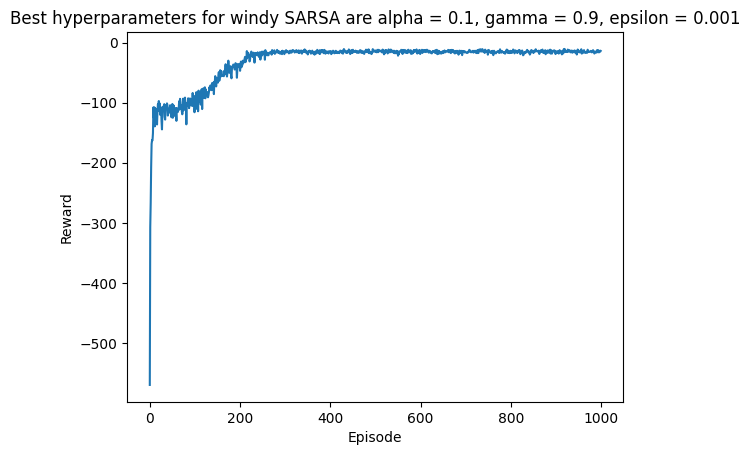

In [ ]:
plot_reward(rewards, title)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

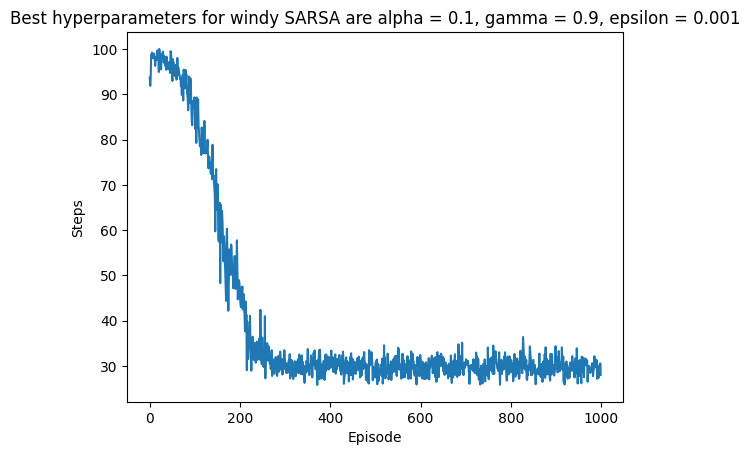

In [ ]:
plot_steps_to_goal(steps_to_goal, title)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

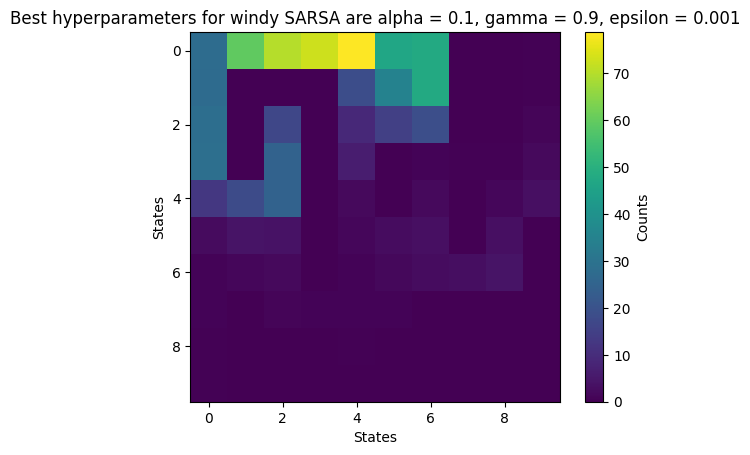

In [ ]:
plot_state_visit_counts(state_visit_counts, title)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

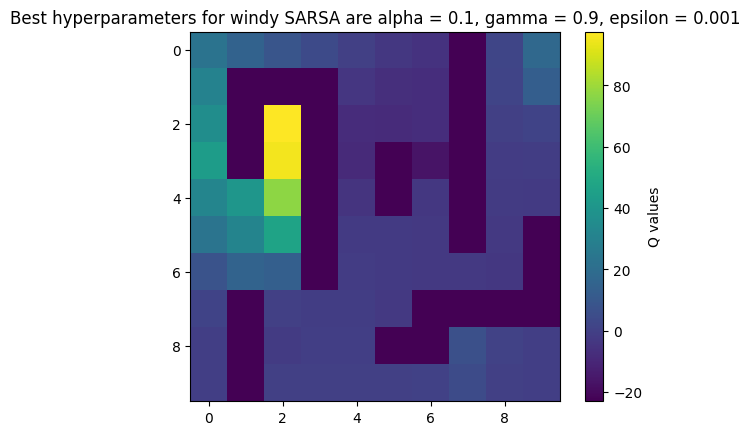

In [ ]:
visualize_policy(env, pi)
plot_q_values(env, q, title)

### (2) Configuration id - not windy deterministic epsilon-greedy SARSA with start state (0, 4)

#### Configuration Parameters
Learning algorithm = SARSA

Wind = FALSE

Start State = (0, 4)

Value of $p$ = 1.0

Exploration strategy = epsilon-greedy

Train the agent

In [ ]:
# write your code here
best_hyperparameters = train_agent('SARSA', False, 1.0, np.array([[0,4]]), False)
title = 'Best hyperparameters for not windy SARSA are alpha = ' + str(best_hyperparameters[0]) + ', gamma = ' + str(best_hyperparameters[1]) + ', epsilon = ' + str(best_hyperparameters[2])
print(title)
(q, pi, state_counts, rewards, steps_to_goal) = sarsa(env, alpha=best_hyperparameters[0], gamma=best_hyperparameters[1], start_state=np.array([[0, 4]]), start_state_seq=row_col_to_seq(np.array([[0, 4]]), 10), p=1.0, is_softmax=False, wind=False, epsilon=best_hyperparameters[2], num_agents = 50)
# Reshape state visit counts for visualization
state_visit_counts = state_counts.reshape((10, 10))

Best hyperparameters for not windy SARSA are alpha = 0.1, gamma = 1.0, epsilon = 0.001


1. Plot reward curves (during the training phase with the best hyperparameters).

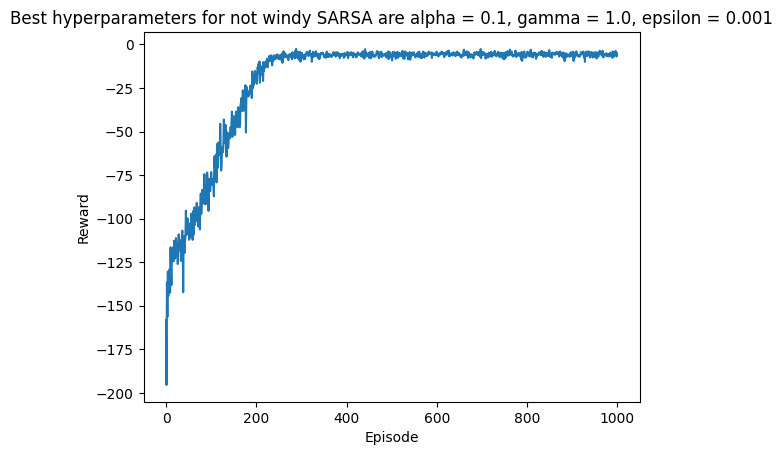

In [ ]:
plot_reward(rewards, title)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

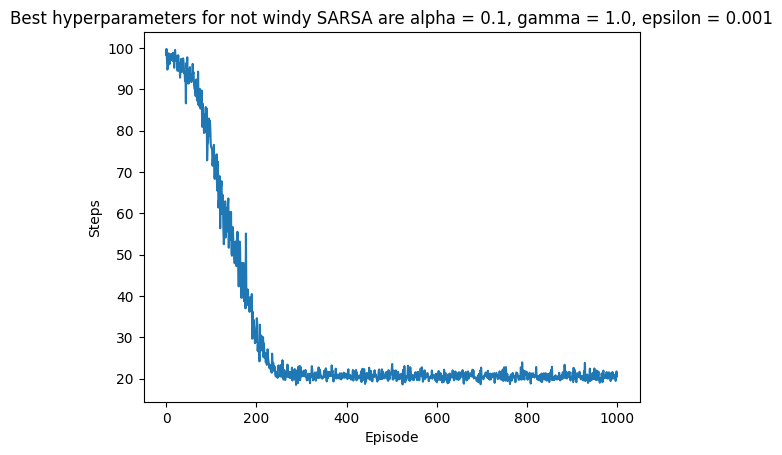

In [ ]:
plot_steps_to_goal(steps_to_goal, title)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

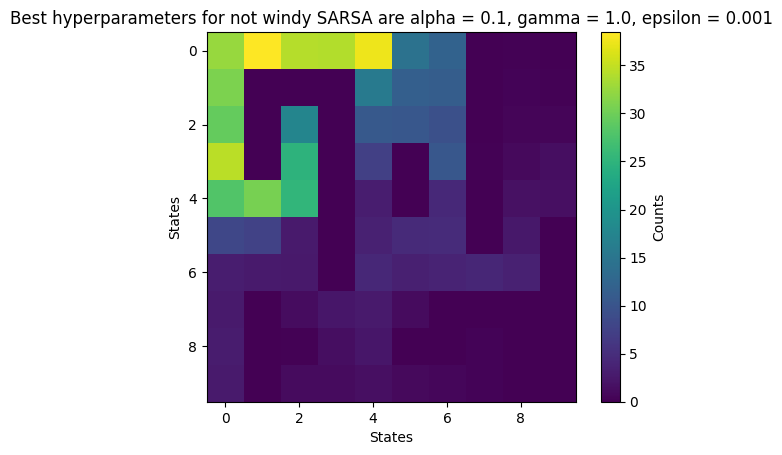

In [ ]:
plot_state_visit_counts(state_visit_counts, title)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

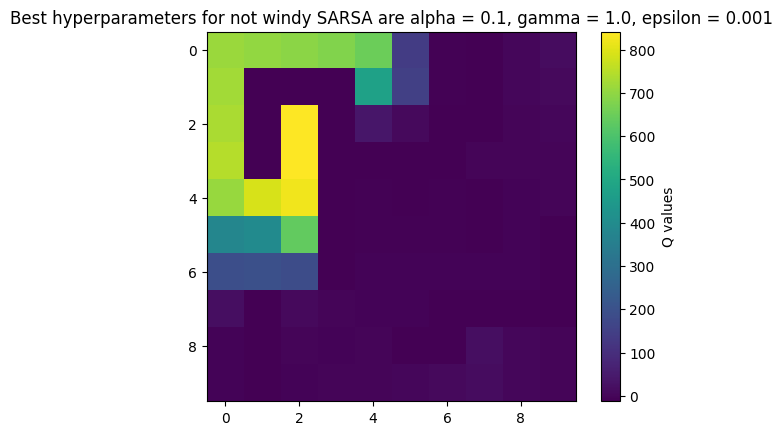

In [ ]:
visualize_policy(env, pi)
plot_q_values(env, q, title)

### (3) Configuration id - windy deterministic softmax SARSA with start state (0, 4)

#### Configuration Parameters
Learning algorithm = SARSA

Wind = TRUE

Start State = (0, 4)

Value of $p$ = 1.0

Exploration strategy = softmax

Train the agent

In [ ]:
# write your code here
best_hyperparameters = train_agent('SARSA', True, 1.0, np.array([[0,4]]), True)
title = 'Best hyperparameters for windy SARSA are alpha = ' + str(best_hyperparameters[0]) + ', gamma = ' + str(best_hyperparameters[1]) + ', temprature = ' + str(best_hyperparameters[2])
print(title)
(q, pi, state_counts, rewards, steps_to_goal) = sarsa(env, alpha=best_hyperparameters[0], gamma=best_hyperparameters[1], start_state=np.array([[0, 4]]), start_state_seq=row_col_to_seq(np.array([[0, 4]]), 10), p=1.0, is_softmax=True, wind=True, temprature=best_hyperparameters[2], num_agents = 50)
# Reshape state visit counts for visualization
state_visit_counts = state_counts.reshape((10, 10))

Best hyperparameters for windy SARSA are alpha = 0.1, gamma = 0.9, temprature = 0.01


1. Plot reward curves (during the training phase with the best hyperparameters).

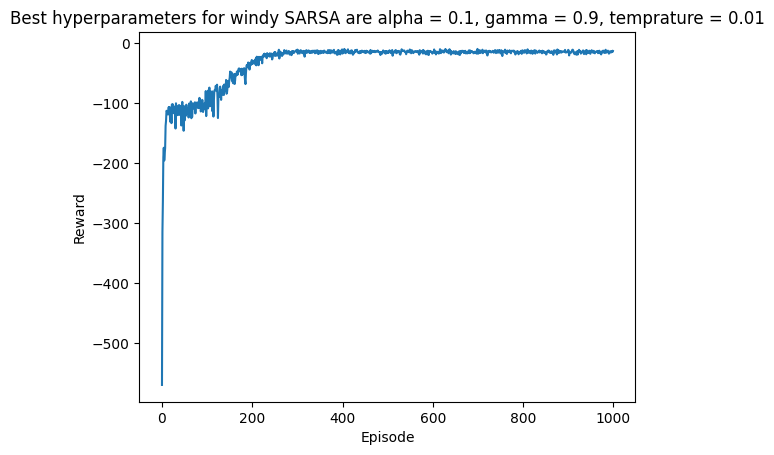

In [ ]:
plot_reward(rewards, title)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

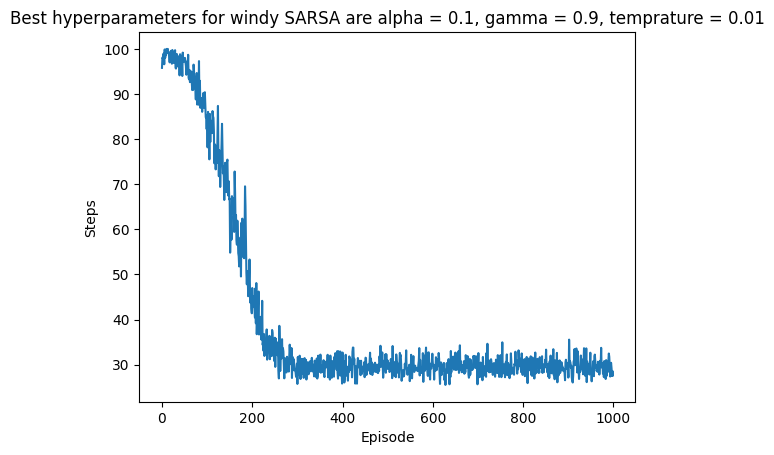

In [ ]:
plot_steps_to_goal(steps_to_goal, title)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

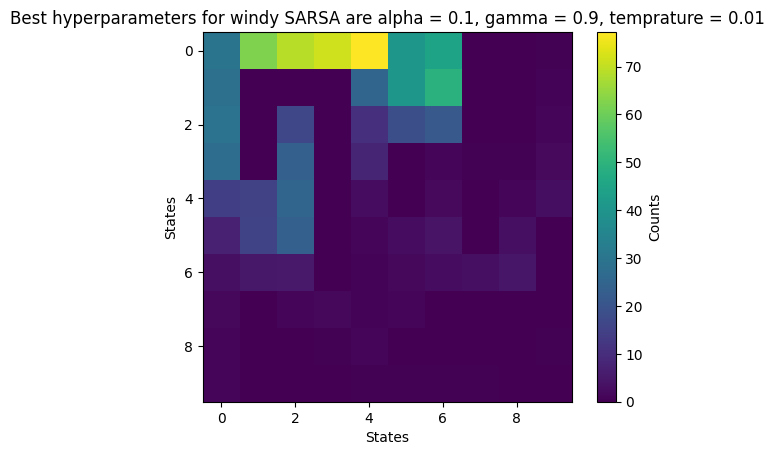

In [ ]:
plot_state_visit_counts(state_visit_counts, title)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

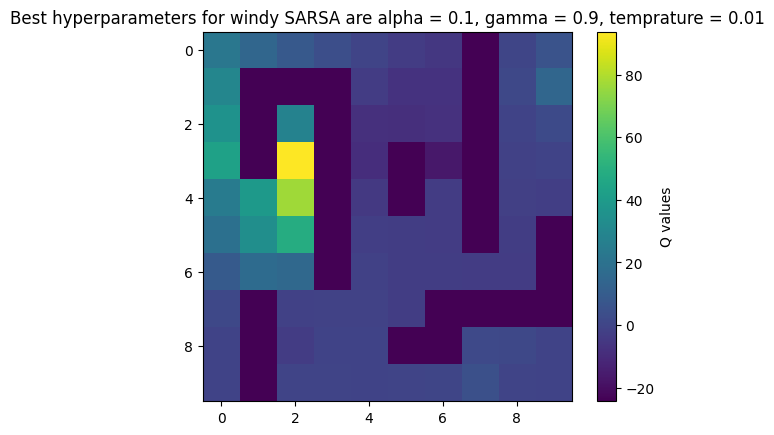

In [ ]:
visualize_policy(env, pi)
plot_q_values(env, q, title)

### (4) Configuration id - not windy deterministic softmax SARSA with start state (0, 4)

#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (0, 4)

Value of $p$ = 1.0

Exploration strategy = softmax

Train the agent

In [ ]:
# write your code here
best_hyperparameters = train_agent('SARSA', False, 1.0, np.array([[0,4]]), True)
title = 'Best hyperparameters for not windy SARSA are alpha = ' + str(best_hyperparameters[0]) + ', gamma = ' + str(best_hyperparameters[1]) + ', temprature = ' + str(best_hyperparameters[2])
print(title)
(q, pi, state_counts, rewards, steps_to_goal) = sarsa(env, alpha=best_hyperparameters[0], gamma=best_hyperparameters[1], start_state=np.array([[0, 4]]), start_state_seq=row_col_to_seq(np.array([[0, 4]]), 10), p=1.0, is_softmax=True, wind=False, temprature=best_hyperparameters[2], num_agents = 50)
# Reshape state visit counts for visualization
state_visit_counts = state_counts.reshape((10, 10))

Best hyperparameters for not windy SARSA are alpha = 0.1, gamma = 1.0, temprature = 0.01


1. Plot reward curves (during the training phase with the best hyperparameters).

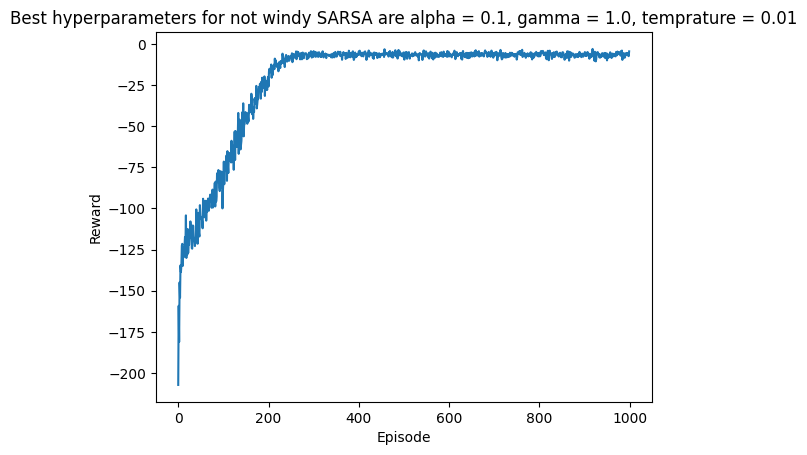

In [ ]:
plot_reward(rewards, title)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

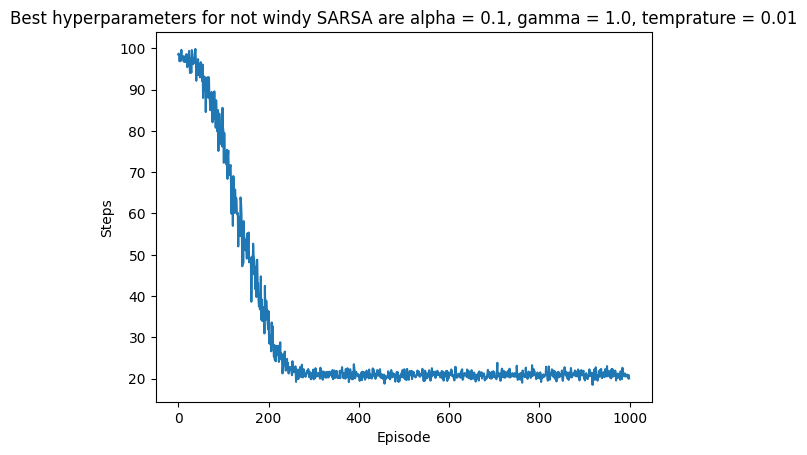

In [ ]:
plot_steps_to_goal(steps_to_goal, title)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

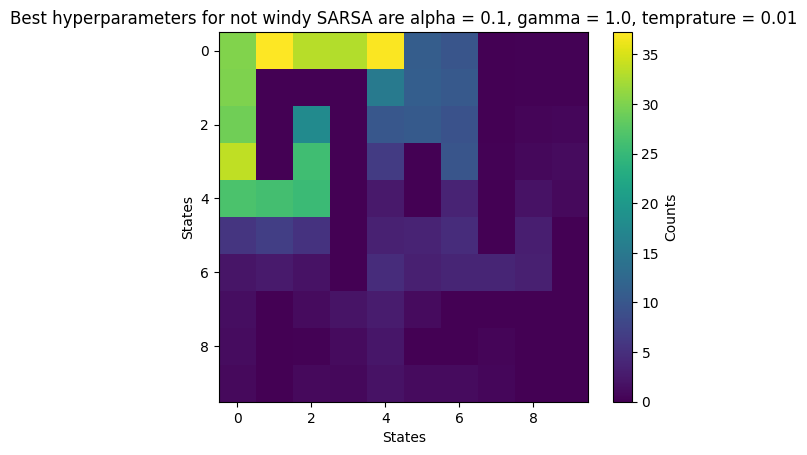

In [ ]:
plot_state_visit_counts(state_visit_counts, title)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

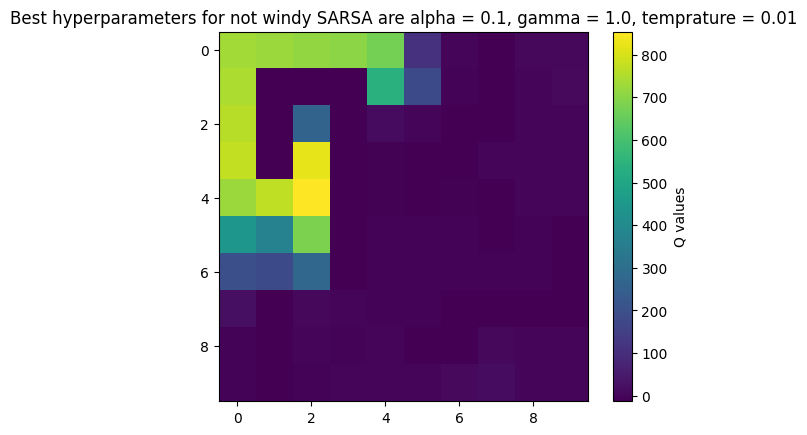

In [ ]:
visualize_policy(env, pi)
plot_q_values(env, q, title)

### (5) Configuration id - windy deterministic epsilon-greedy SARSA with start state (3, 6)

#### Configuration Parameters
Learning algorithm = SARSA

Wind = TRUE

Start State = (3, 6)

Value of $p$ = 1.0

Exploration strategy = epsilon-greedy

Train the agent

In [ ]:
# write your code here
best_hyperparameters = train_agent('SARSA', True, 1.0, np.array([[3, 6]]), False)
title = 'Best hyperparameters for windy SARSA are alpha = ' + str(best_hyperparameters[0]) + ', gamma = ' + str(best_hyperparameters[1]) + ', epsilon = ' + str(best_hyperparameters[2])
print(title)
(q, pi, state_counts, rewards, steps_to_goal) = sarsa(env, alpha=best_hyperparameters[0], gamma=best_hyperparameters[1], start_state=np.array([[3, 6]]), start_state_seq=row_col_to_seq(np.array([[3, 6]]), 10), p=1.0, is_softmax=False, wind=True, epsilon=best_hyperparameters[2], num_agents = 50)
# Reshape state visit counts for visualization
state_visit_counts = state_counts.reshape((10, 10))

Best hyperparameters for windy SARSA are alpha = 0.1, gamma = 1.0, epsilon = 0.001


1. Plot reward curves (during the training phase with the best hyperparameters).

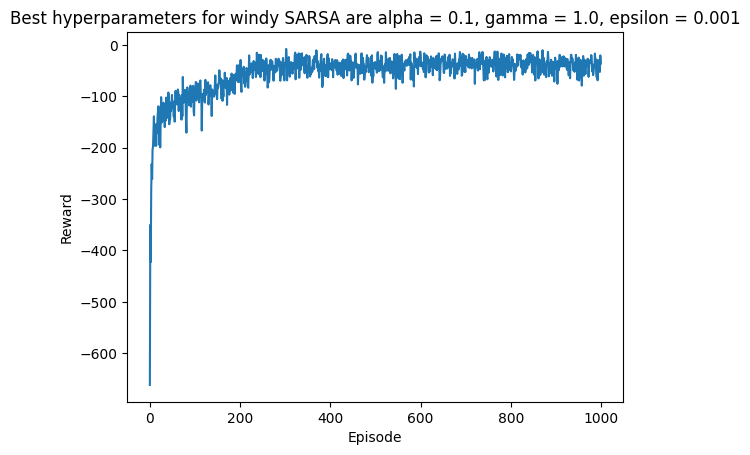

In [ ]:
plot_reward(rewards, title)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

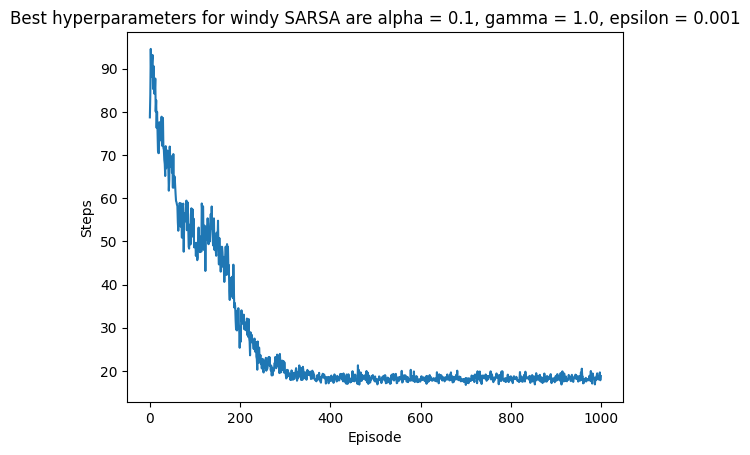

In [ ]:
plot_steps_to_goal(steps_to_goal, title)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

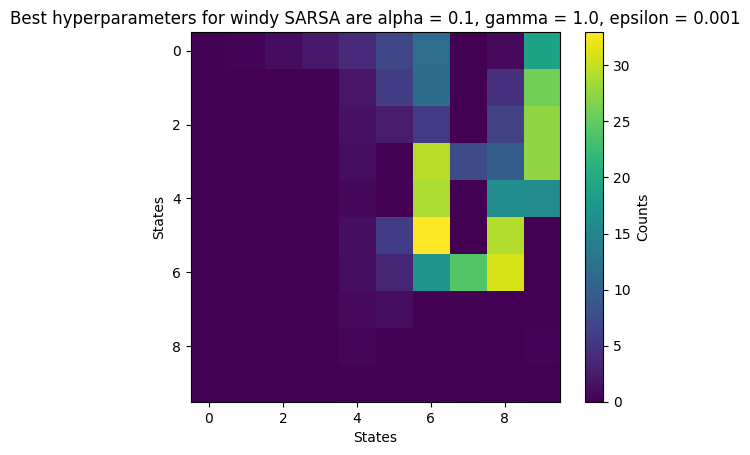

In [ ]:
plot_state_visit_counts(state_visit_counts, title)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

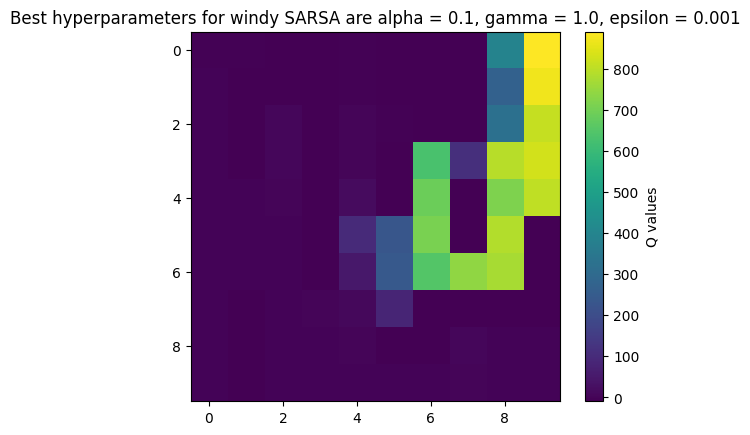

In [ ]:
visualize_policy(env, pi)
plot_q_values(env, q, title)

### (6) Configuration id - not windy deterministic epsilon-greedy SARSA with start state (3, 6)

#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (3, 6)

Value of $p$ = 1.0

Exploration strategy = epsilon-greedy

Train the agent

In [ ]:
# write your code here
best_hyperparameters = train_agent('SARSA', False, 1.0, np.array([[3, 6]]), False)
title = 'Best hyperparameters for not windy SARSA are alpha = ' + str(best_hyperparameters[0]) + ', gamma = ' + str(best_hyperparameters[1]) + ', epsilon = ' + str(best_hyperparameters[2])
print(title)
(q, pi, state_counts, rewards, steps_to_goal) = sarsa(env, alpha=best_hyperparameters[0], gamma=best_hyperparameters[1], start_state=np.array([[3, 6]]), start_state_seq=row_col_to_seq(np.array([[3, 6]]), 10), p=1.0, is_softmax=False, wind=False, epsilon=best_hyperparameters[2], num_agents = 50)
# Reshape state visit counts for visualization
state_visit_counts = state_counts.reshape((10, 10))

Best hyperparameters for not windy SARSA are alpha = 0.1, gamma = 1.0, epsilon = 0.001


1. Plot reward curves (during the training phase with the best hyperparameters).

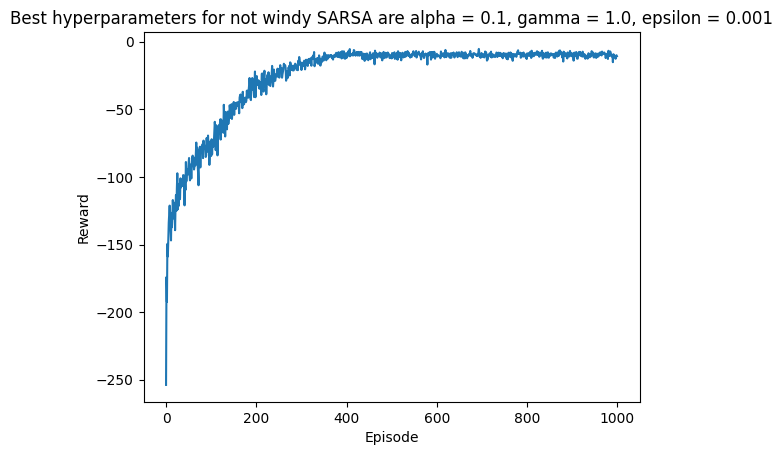

In [ ]:
plot_reward(rewards, title)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

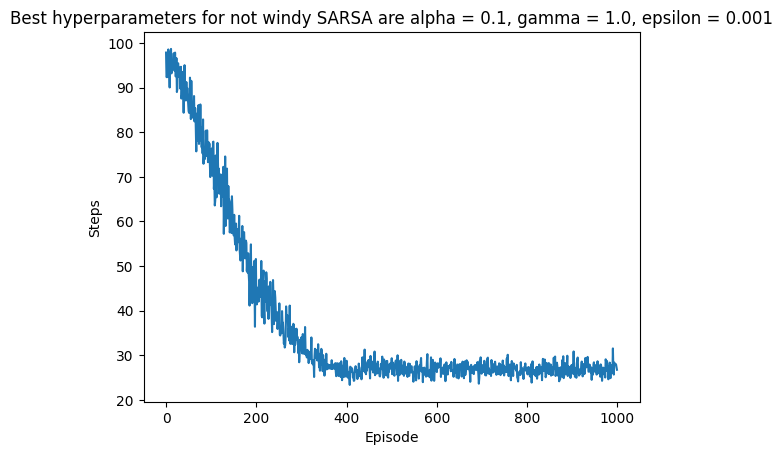

In [ ]:
plot_steps_to_goal(steps_to_goal, title)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

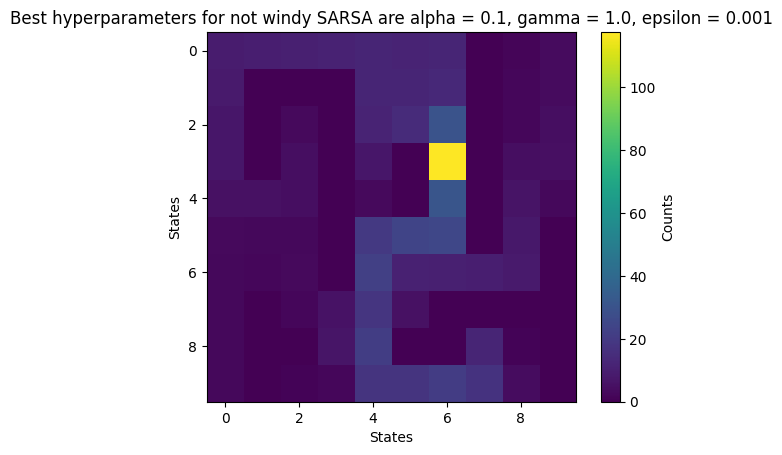

In [ ]:
plot_state_visit_counts(state_visit_counts, title)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

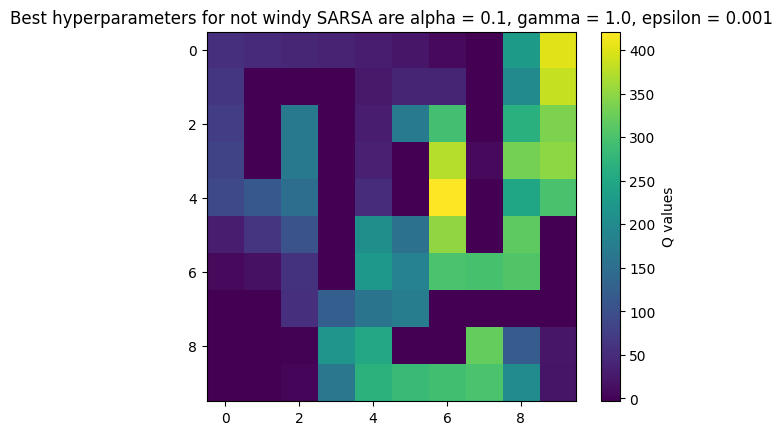

In [ ]:
visualize_policy(env, pi)
plot_q_values(env, q, title)

### (7) Configuration id - windy deterministic softmax SARSA with start state (3, 6)

#### Configuration Parameters
Learning algorithm = SARSA

Wind = TRUE

Start State = (3, 6)

Value of $p$ = 1.0

Exploration strategy = softmax

Train the agent

In [ ]:
# write your code here
best_hyperparameters = train_agent('SARSA', True, 1.0, np.array([[3, 6]]), True)
title = 'Best hyperparameters for windy SARSA are alpha = ' + str(best_hyperparameters[0]) + ', gamma = ' + str(best_hyperparameters[1]) + ', temprature = ' + str(best_hyperparameters[2])
print(title)
(q, pi, state_counts, rewards, steps_to_goal) = sarsa(env, alpha=best_hyperparameters[0], gamma=best_hyperparameters[1], start_state=np.array([[3, 6]]), start_state_seq=row_col_to_seq(np.array([[3, 6]]), 10), p=1.0, is_softmax=True, wind=True, temprature=best_hyperparameters[2], num_agents = 50)
# Reshape state visit counts for visualization
state_visit_counts = state_counts.reshape((10, 10))

Best hyperparameters for windy SARSA are alpha = 0.1, gamma = 1.0, temprature = 0.01


1. Plot reward curves (during the training phase with the best hyperparameters).

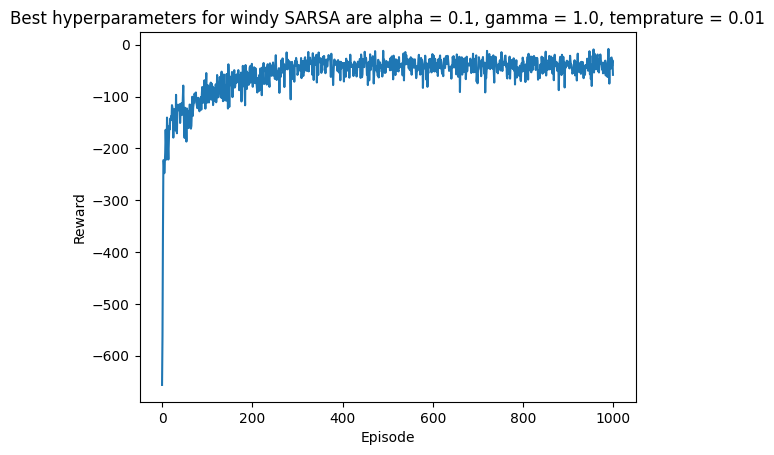

In [ ]:
plot_reward(rewards, title)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

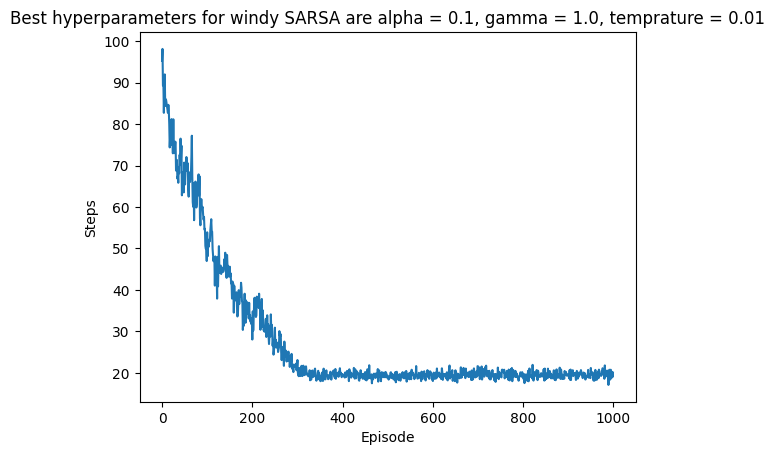

In [ ]:
plot_steps_to_goal(steps_to_goal, title)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

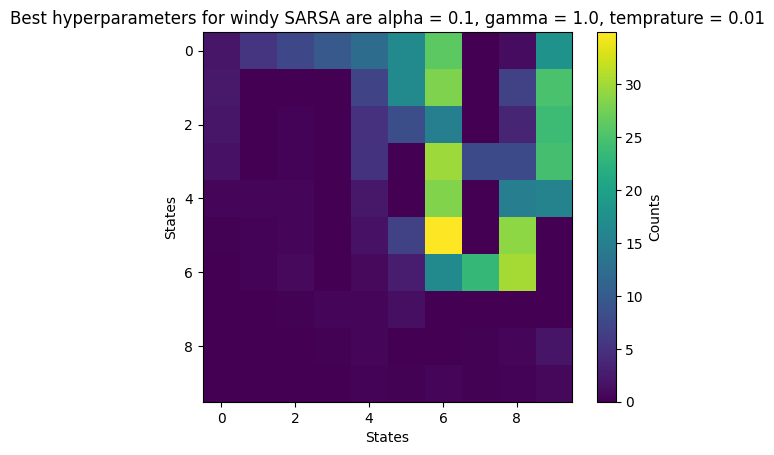

In [ ]:
plot_state_visit_counts(state_visit_counts, title)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

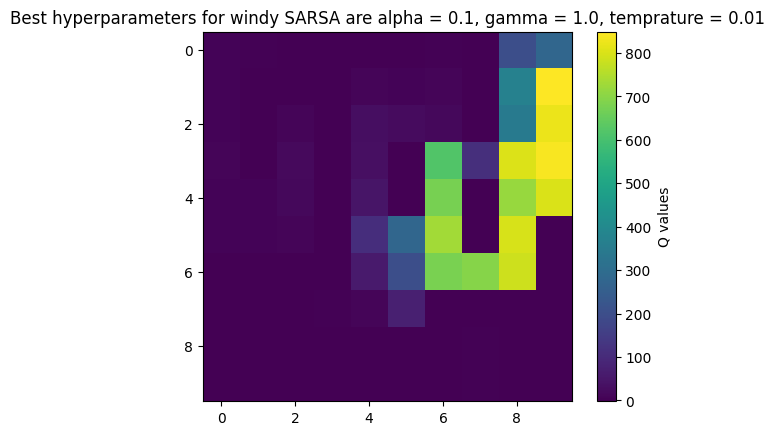

In [ ]:
visualize_policy(env, pi)
plot_q_values(env, q, title)

### (8) Configuration id - not windy deterministic softmax SARSA with start state (3, 6)

#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (3, 6)

Value of $p$ = 1.0

Exploration strategy = softmax

Train the agent

In [ ]:
# write your code here
best_hyperparameters = train_agent('SARSA', False, 1.0, np.array([[3, 6]]), True)
title = 'Best hyperparameters for not windy SARSA are alpha = ' + str(best_hyperparameters[0]) + ', gamma = ' + str(best_hyperparameters[1]) + ', temprature = ' + str(best_hyperparameters[2])
print(title)
(q, pi, state_counts, rewards, steps_to_goal) = sarsa(env, alpha=best_hyperparameters[0], gamma=best_hyperparameters[1], start_state=np.array([[3, 6]]), start_state_seq=row_col_to_seq(np.array([[3, 6]]), 10), p=1.0, is_softmax=True, wind=False, temprature=best_hyperparameters[2], num_agents = 50)
# Reshape state visit counts for visualization
state_visit_counts = state_counts.reshape((10, 10))

Best hyperparameters for not windy SARSA are alpha = 0.1, gamma = 1.0, temprature = 0.01


1. Plot reward curves (during the training phase with the best hyperparameters).

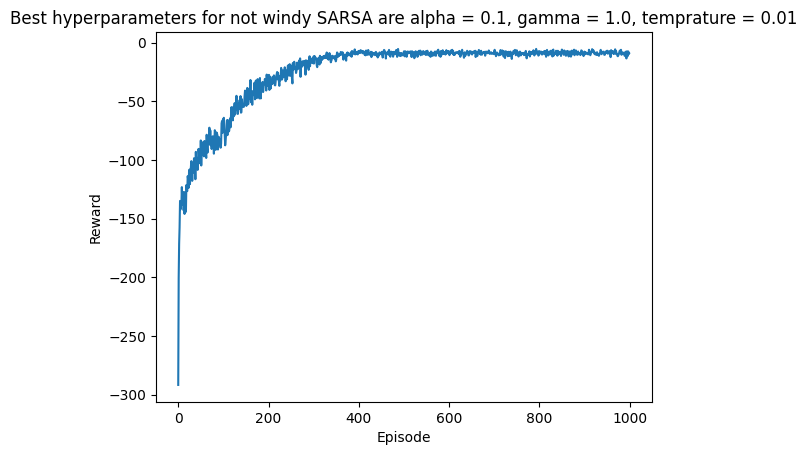

In [ ]:
plot_reward(rewards, title)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

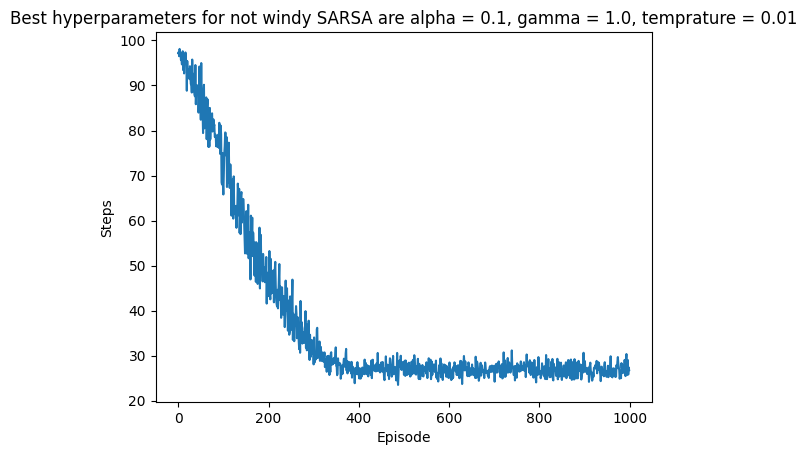

In [ ]:
plot_steps_to_goal(steps_to_goal, title)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

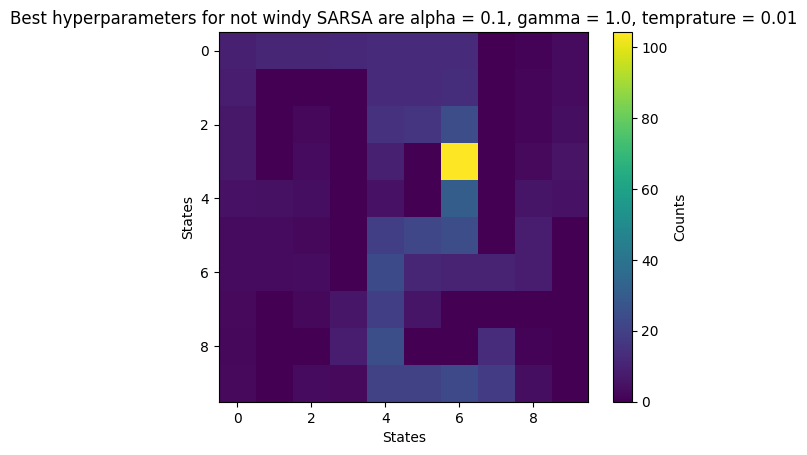

In [ ]:
plot_state_visit_counts(state_visit_counts, title)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

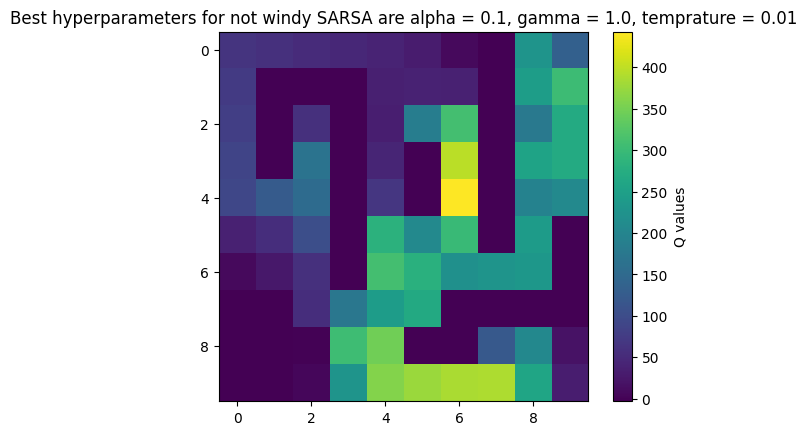

In [ ]:
visualize_policy(env, pi)
plot_q_values(env, q, title)

### (9) Configuration id - not windy deterministic epsilon-greedy QLearning with start state (0, 4)

#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (0, 4)

Value of $p$ = 1.0

Exploration strategy = epsilon-greedy

Train the agent

In [ ]:
# write your code here
best_hyperparameters = train_agent('QLearning', False, 1.0, np.array([[0,4]]), False)
title = 'Best hyperparameters for not windy QLearning are alpha = ' + str(best_hyperparameters[0]) + ', gamma = ' + str(best_hyperparameters[1]) + ', epsilon = ' + str(best_hyperparameters[2])
print(title)
(q, pi, state_counts, rewards, steps_to_goal) = qlearning(env, alpha=best_hyperparameters[0], gamma=best_hyperparameters[1], start_state=np.array([[0, 4]]), start_state_seq=row_col_to_seq(np.array([[0, 4]]), 10), p=1.0, is_softmax=False, wind=False, epsilon=best_hyperparameters[2], num_agents = 50)
# Reshape state visit counts for visualization
state_visit_counts = state_counts.reshape((10, 10))

Best hyperparameters for not windy QLearning are alpha = 0.1, gamma = 1.0, epsilon = 0.01


1. Plot reward curves (during the training phase with the best hyperparameters).

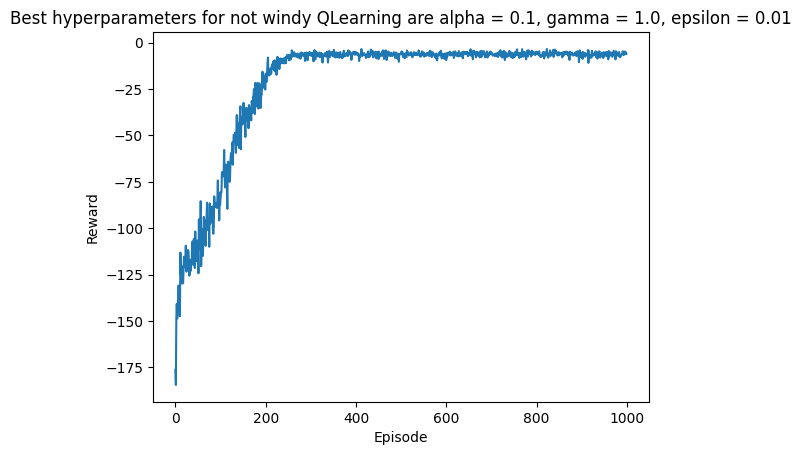

In [ ]:
plot_reward(rewards, title)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

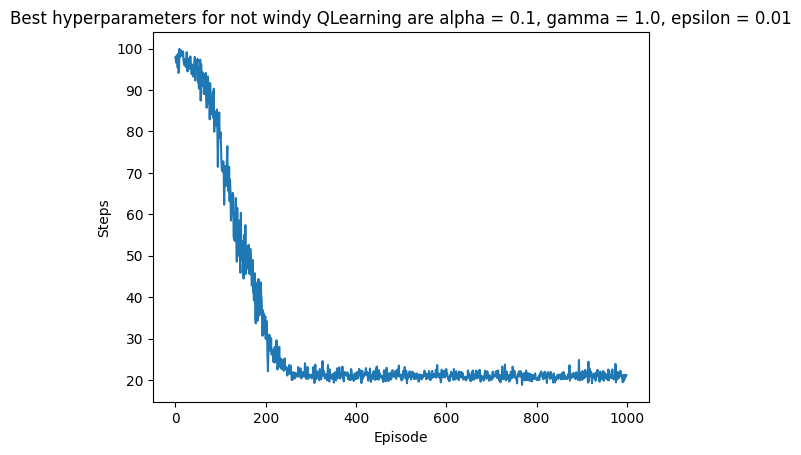

In [ ]:
plot_steps_to_goal(steps_to_goal, title)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

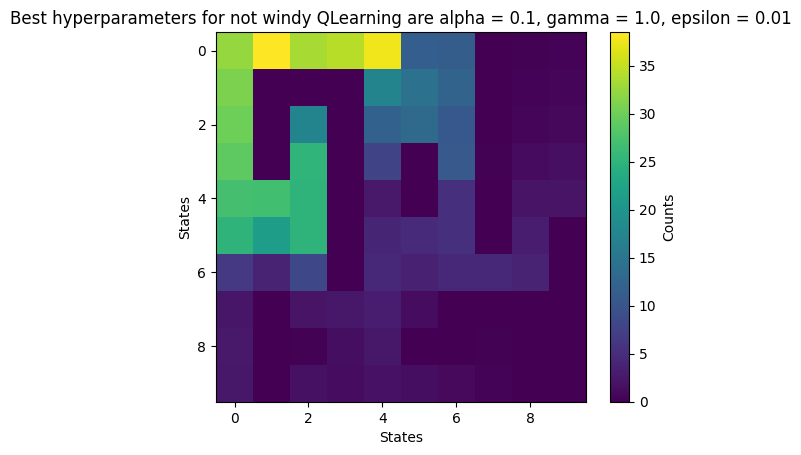

In [ ]:
plot_state_visit_counts(state_visit_counts, title)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

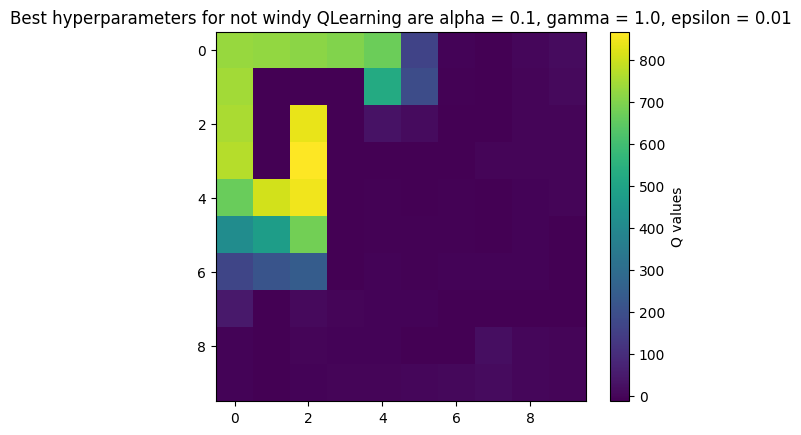

In [ ]:
visualize_policy(env, pi)
plot_q_values(env, q, title)

### (10) Configuration id - not windy non-deterministic epsilon-greedy QLearning with start state (0, 4)

#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (0, 4)

Value of $p$ = 0.7

Exploration strategy = epsilon-greedy

Train the agent

In [ ]:
# write your code here
best_hyperparameters = train_agent('QLearning', False, 0.7, np.array([[0,4]]), False)
title = 'Best hyperparameters for windy QLearning are alpha = ' + str(best_hyperparameters[0]) + ', gamma = ' + str(best_hyperparameters[1]) + ', epsilon = ' + str(best_hyperparameters[2])
print(title)
(q, pi, state_counts, rewards, steps_to_goal) = qlearning(env, alpha=best_hyperparameters[0], gamma=best_hyperparameters[1], start_state=np.array([[0, 4]]), start_state_seq=row_col_to_seq(np.array([[0, 4]]), 10), p=0.7, is_softmax=False, wind=False, epsilon=best_hyperparameters[2], num_agents = 50)
# Reshape state visit counts for visualization
state_visit_counts = state_counts.reshape((10, 10))

Best hyperparameters for windy QLearning are alpha = 0.1, gamma = 1.0, epsilon = 0.01


1. Plot reward curves (during the training phase with the best hyperparameters).

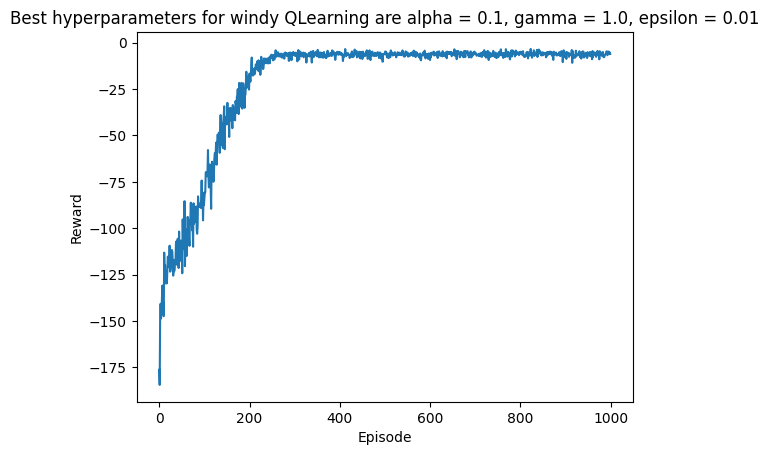

In [ ]:
plot_reward(rewards, title)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

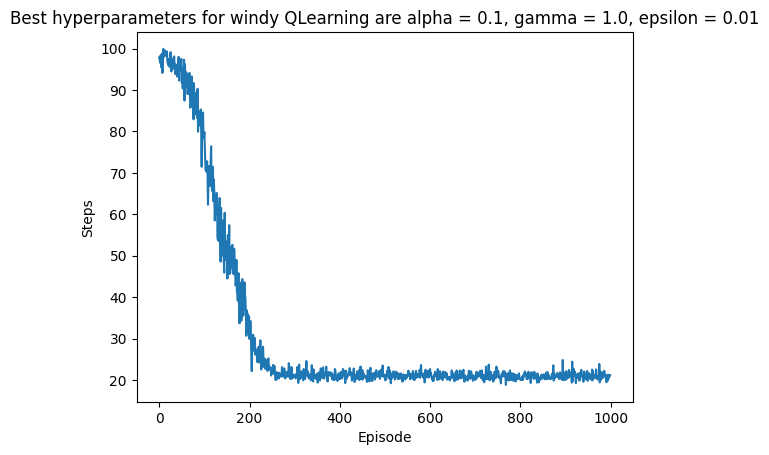

In [ ]:
plot_steps_to_goal(steps_to_goal, title)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

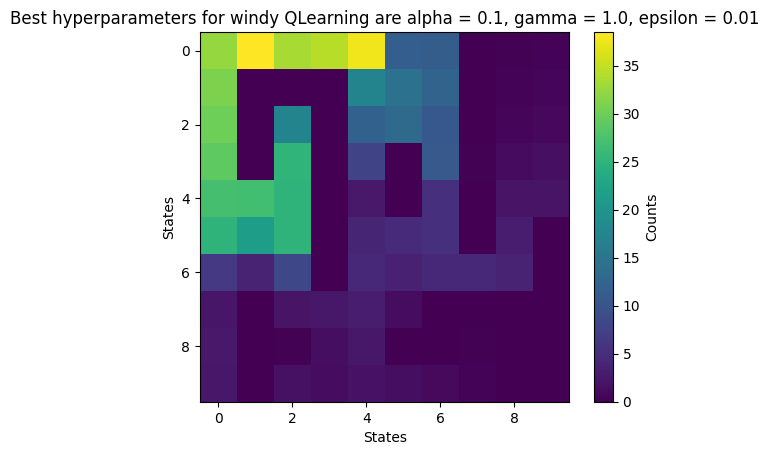

In [ ]:
plot_state_visit_counts(state_visit_counts, title)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

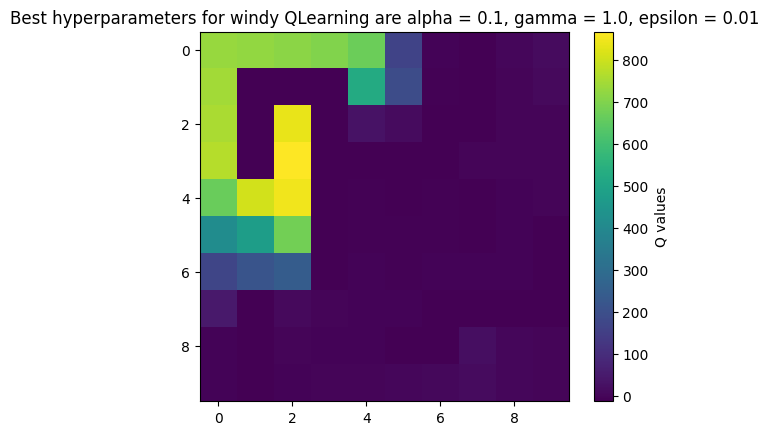

In [ ]:
visualize_policy(env, pi)
plot_q_values(env, q, title)

### (11) Configuration id - not windy deterministic softmax QLearning with start state (0, 4)

#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (0, 4)

Value of $p$ = 1.0

Exploration strategy = softmax

Train the agent

In [ ]:
# write your code here
best_hyperparameters = train_agent('QLearning', False, 1.0, np.array([[0,4]]), True)
title = 'Best hyperparameters for not windy QLearning are alpha = ' + str(best_hyperparameters[0]) + ', gamma = ' + str(best_hyperparameters[1]) + ', temprature = ' + str(best_hyperparameters[2])
print(title)
(q, pi, state_counts, rewards, steps_to_goal) = qlearning(env, alpha=best_hyperparameters[0], gamma=best_hyperparameters[1], start_state=np.array([[0, 4]]), start_state_seq=row_col_to_seq(np.array([[0, 4]]), 10), p=1.0, is_softmax=True, wind=False, temprature=best_hyperparameters[2], num_agents = 50)
# Reshape state visit counts for visualization
state_visit_counts = state_counts.reshape((10, 10))

Best hyperparameters for not windy QLearning are alpha = 0.1, gamma = 1.0, temprature = 0.1


1. Plot reward curves (during the training phase with the best hyperparameters).

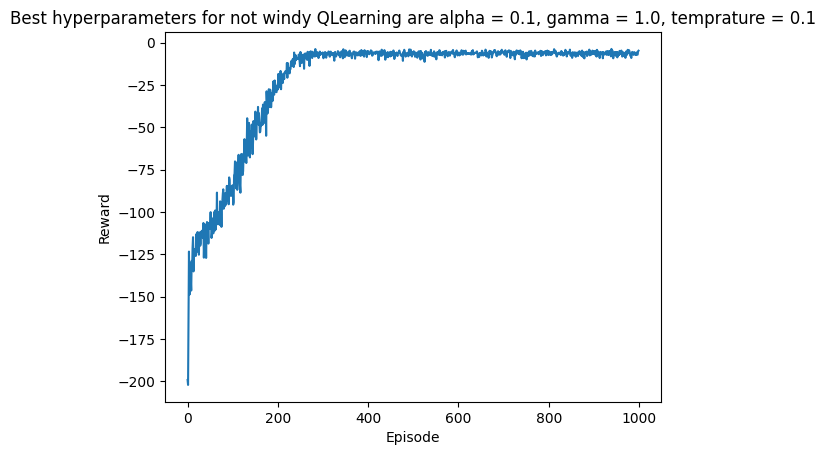

In [ ]:
plot_reward(rewards, title)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

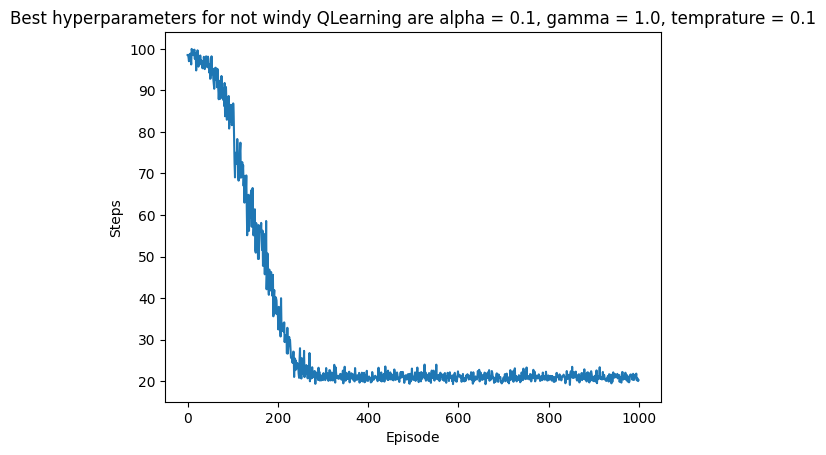

In [ ]:
plot_steps_to_goal(steps_to_goal, title)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

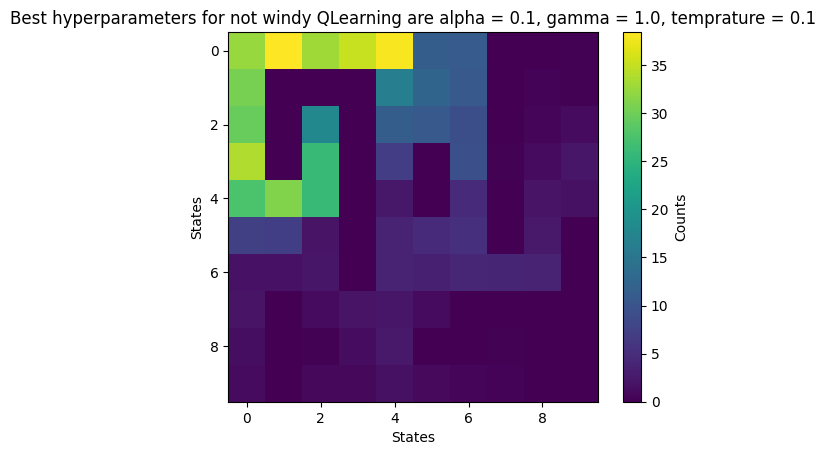

In [ ]:
plot_state_visit_counts(state_visit_counts, title)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

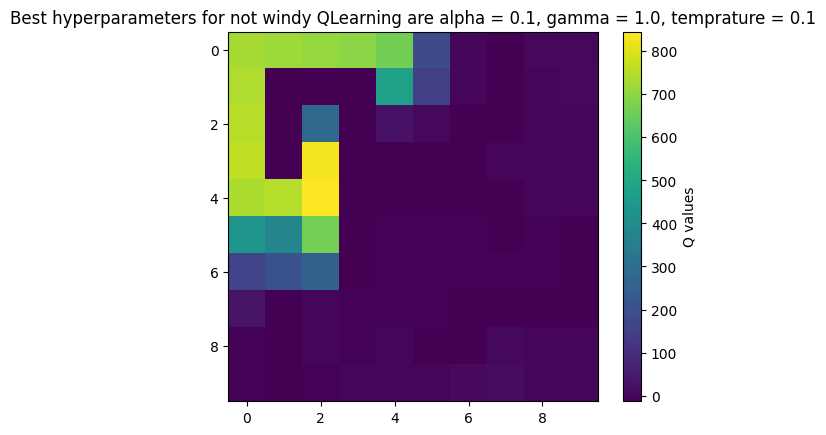

In [ ]:
visualize_policy(env, pi)
plot_q_values(env, q, title)

### (12) Configuration id - not windy non-deterministic softmax QLearning with start state (0, 4)

#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (0, 4)

Value of $p$ = 0.7

Exploration strategy = softmax

Train the agent

In [ ]:
# write your code here
best_hyperparameters = train_agent('QLearning', False, 0.7, np.array([[0,4]]), True)
title = 'Best hyperparameters for windy QLearning are alpha = ' + str(best_hyperparameters[0]) + ', gamma = ' + str(best_hyperparameters[1]) + ', temprature = ' + str(best_hyperparameters[2])
print(title)
(q, pi, state_counts, rewards, steps_to_goal) = qlearning(env, alpha=best_hyperparameters[0], gamma=best_hyperparameters[1], start_state=np.array([[0, 4]]), start_state_seq=row_col_to_seq(np.array([[0, 4]]), 10), p=0.7, is_softmax=True, wind=False, temprature=best_hyperparameters[2], num_agents = 50)
# Reshape state visit counts for visualization
state_visit_counts = state_counts.reshape((10, 10))

Best hyperparameters for windy QLearning are alpha = 0.1, gamma = 1.0, temprature = 0.1


1. Plot reward curves (during the training phase with the best hyperparameters).

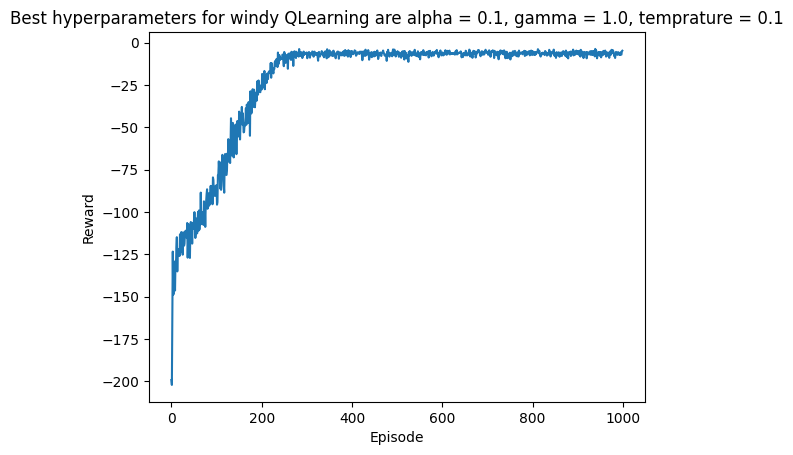

In [ ]:
plot_reward(rewards, title)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

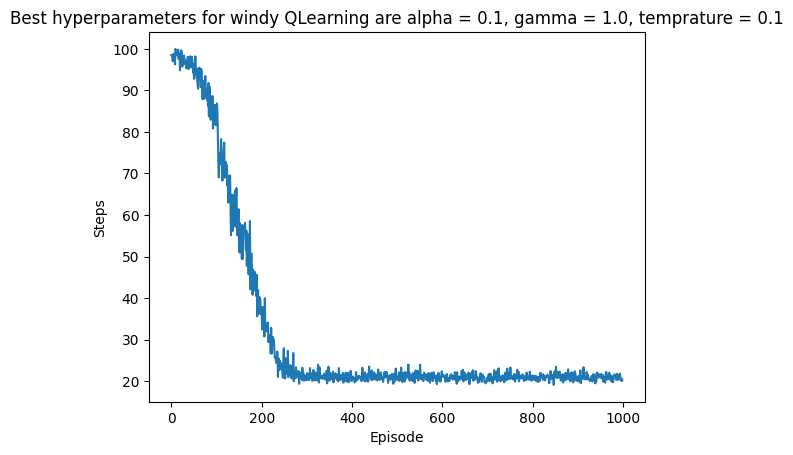

In [ ]:
plot_steps_to_goal(steps_to_goal, title)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

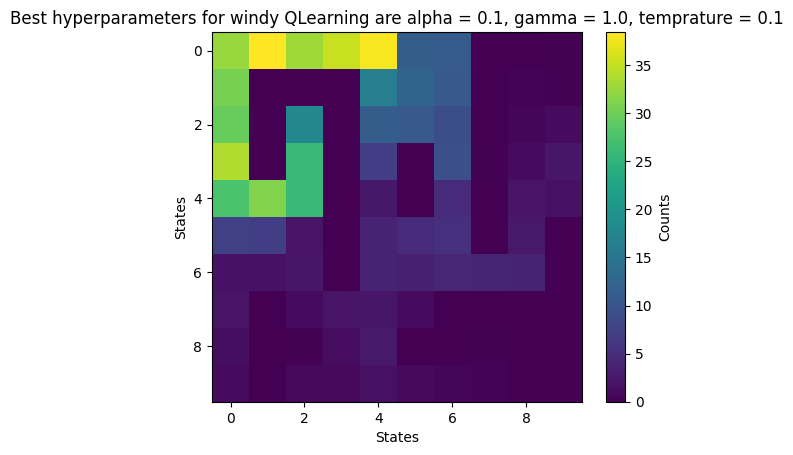

In [ ]:
plot_state_visit_counts(state_visit_counts, title)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

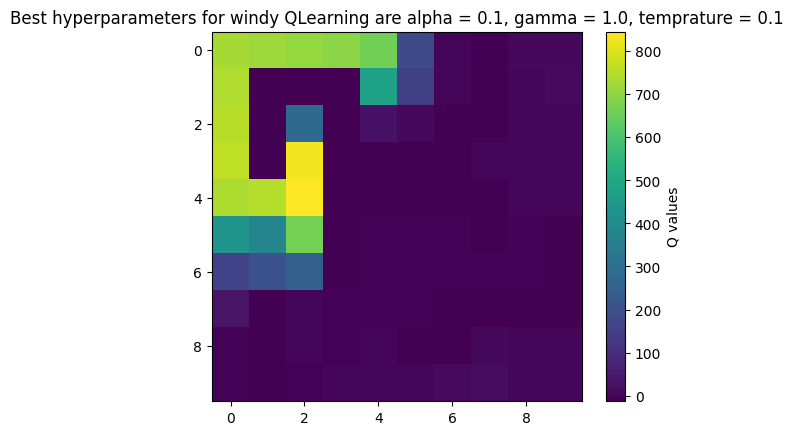

In [ ]:
visualize_policy(env, pi)
plot_q_values(env, q, title)

### (13) Configuration id - not windy deterministic epsilon-greedy QLearning with start state (3, 6)

#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (3, 6)

Value of $p$ = 1.0

Exploration strategy = epsilon-greedy

Train the agent

In [ ]:
# write your code here
best_hyperparameters = train_agent('QLearning', False, 1.0, np.array([[3, 6]]), False)
title = 'Best hyperparameters for not windy QLearning are alpha = ' + str(best_hyperparameters[0]) + ', gamma = ' + str(best_hyperparameters[1]) + ', epsilon = ' + str(best_hyperparameters[2])
print(title)
(q, pi, state_counts, rewards, steps_to_goal) = qlearning(env, alpha=best_hyperparameters[0], gamma=best_hyperparameters[1], start_state=np.array([[3, 6]]), start_state_seq=row_col_to_seq(np.array([[3, 6]]), 10), p=1.0, is_softmax=False, wind=False, epsilon=best_hyperparameters[2], num_agents = 50)
# Reshape state visit counts for visualization
state_visit_counts = state_counts.reshape((10, 10))

Best hyperparameters for not windy QLearning are alpha = 0.1, gamma = 1.0, epsilon = 0.001


1. Plot reward curves (during the training phase with the best hyperparameters).

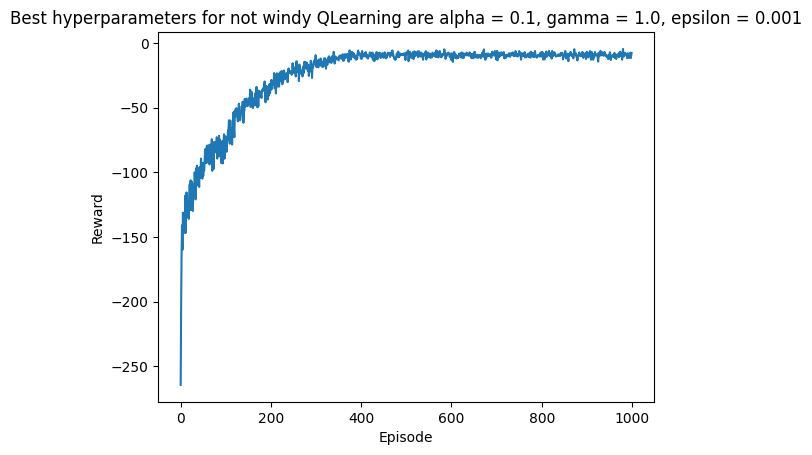

In [ ]:
plot_reward(rewards, title)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

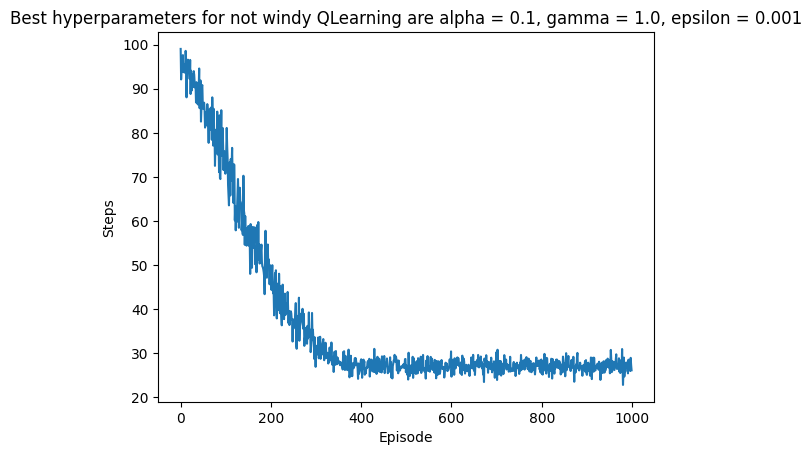

In [ ]:
plot_steps_to_goal(steps_to_goal, title)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

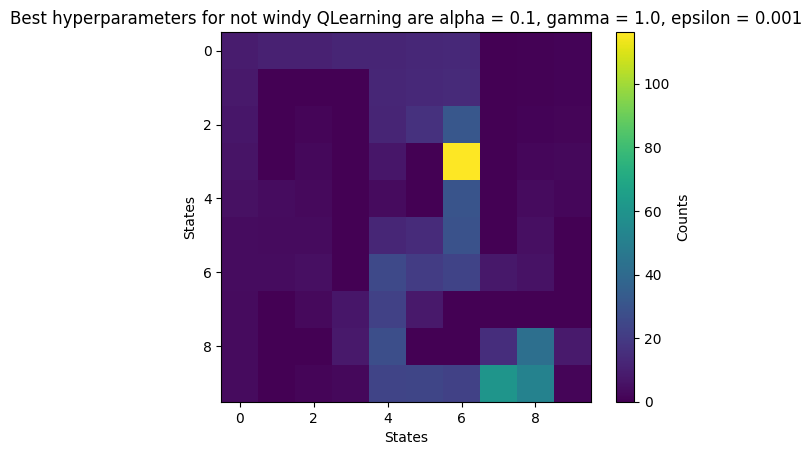

In [ ]:
plot_state_visit_counts(state_visit_counts, title)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

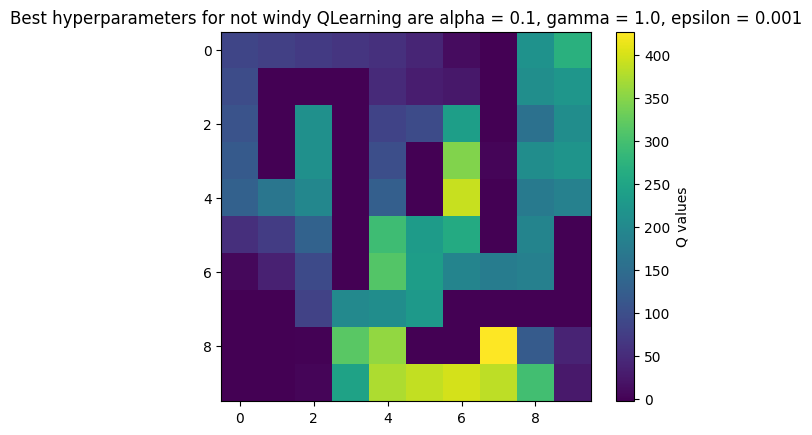

In [ ]:
visualize_policy(env, pi)
plot_q_values(env, q, title)

### (14) Configuration id - not windy non-deterministic epsilon-greedy QLearning with start state (3, 6)

#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (3, 6)

Value of $p$ = 0.7

Exploration strategy = epsilon-greedy

Train the agent

In [ ]:
# write your code here
best_hyperparameters = train_agent('QLearning', False, 0.7, np.array([[3, 6]]), False)
title = 'Best hyperparameters for windy QLearning are alpha = ' + str(best_hyperparameters[0]) + ', gamma = ' + str(best_hyperparameters[1]) + ', epsilon = ' + str(best_hyperparameters[2])
print(title)
(q, pi, state_counts, rewards, steps_to_goal) = qlearning(env, alpha=best_hyperparameters[0], gamma=best_hyperparameters[1], start_state=np.array([[3, 6]]), start_state_seq=row_col_to_seq(np.array([[3, 6]]), 10), p=0.7, is_softmax=False, wind=False, epsilon=best_hyperparameters[2], num_agents = 50)
# Reshape state visit counts for visualization
state_visit_counts = state_counts.reshape((10, 10))

Best hyperparameters for windy QLearning are alpha = 0.1, gamma = 1.0, epsilon = 0.001


1. Plot reward curves (during the training phase with the best hyperparameters).

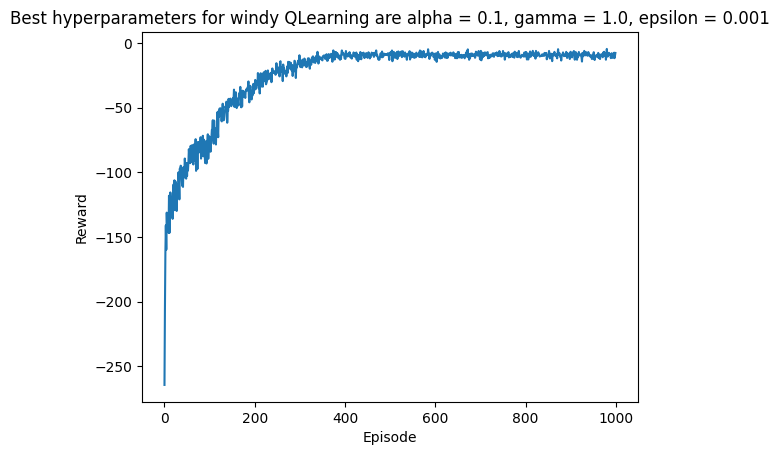

In [ ]:
plot_reward(rewards, title)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

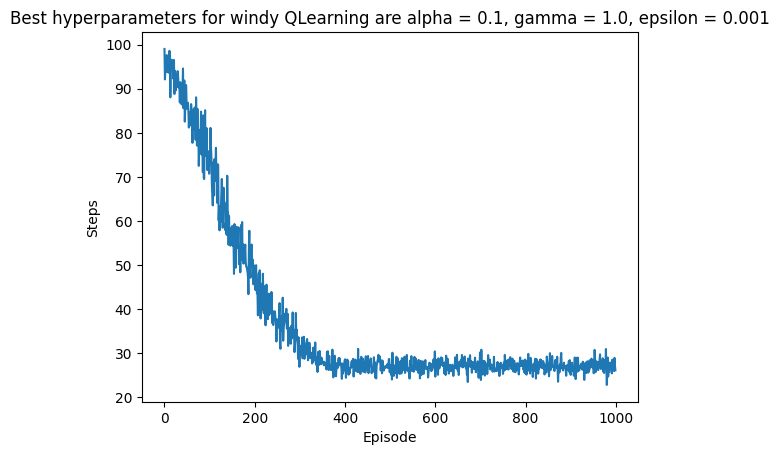

In [ ]:
plot_steps_to_goal(steps_to_goal, title)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

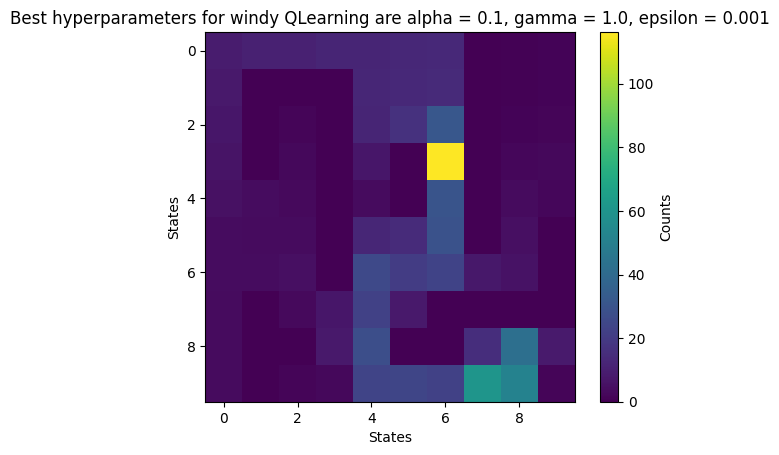

In [ ]:
plot_state_visit_counts(state_visit_counts, title)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

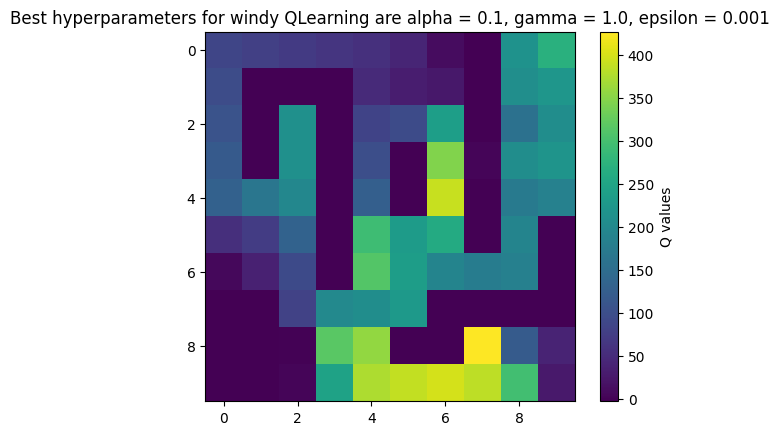

In [ ]:
visualize_policy(env, pi)
plot_q_values(env, q, title)

### (15) Configuration id - not windy deterministic softmax QLearning with start state (3, 6)

#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (3, 6)

Value of $p$ = 1.0

Exploration strategy = softmax

Train the agent

In [ ]:
# write your code here
best_hyperparameters = train_agent('QLearning', False, 1.0, np.array([[3, 6]]), True)
title = 'Best hyperparameters for not windy QLearning are alpha = ' + str(best_hyperparameters[0]) + ', gamma = ' + str(best_hyperparameters[1]) + ', temprature = ' + str(best_hyperparameters[2])
print(title)
(q, pi, state_counts, rewards, steps_to_goal) = qlearning(env, alpha=best_hyperparameters[0], gamma=best_hyperparameters[1], start_state=np.array([[3, 6]]), start_state_seq=row_col_to_seq(np.array([[3, 6]]), 10), p=1.0, is_softmax=True, wind=False, temprature=best_hyperparameters[2], num_agents = 50)
# Reshape state visit counts for visualization
state_visit_counts = state_counts.reshape((10, 10))

Best hyperparameters for not windy QLearning are alpha = 0.1, gamma = 1.0, temprature = 0.01


1. Plot reward curves (during the training phase with the best hyperparameters).

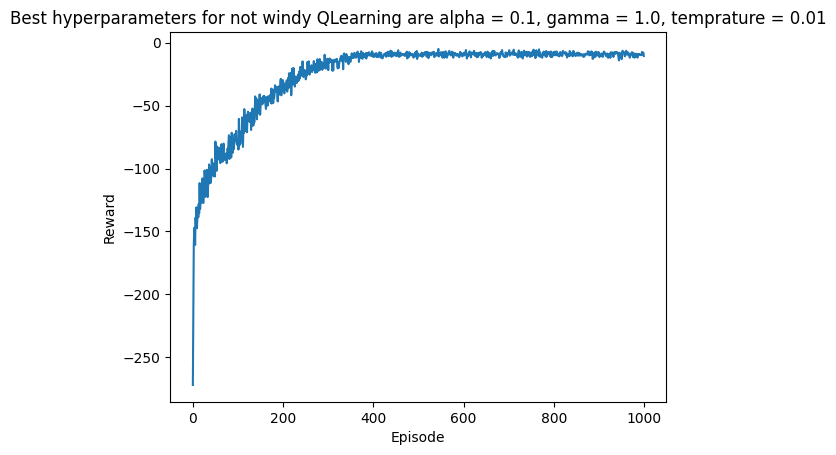

In [ ]:
plot_reward(rewards, title)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

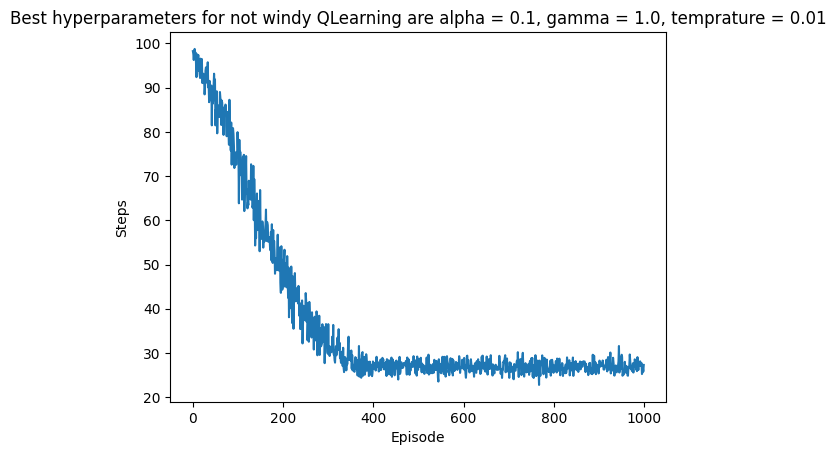

In [ ]:
plot_steps_to_goal(steps_to_goal, title)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

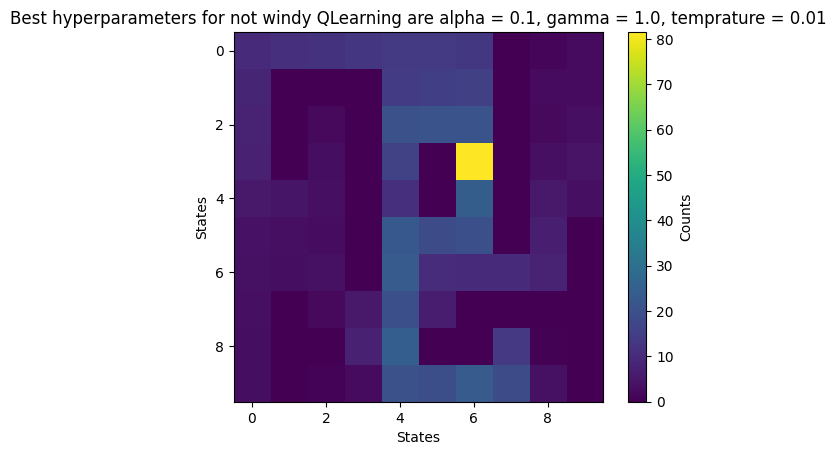

In [ ]:
plot_state_visit_counts(state_visit_counts, title)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

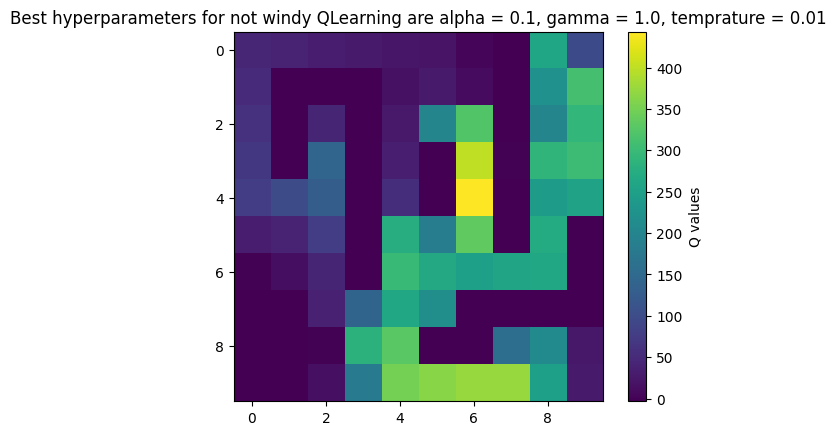

In [ ]:
visualize_policy(env, pi)
plot_q_values(env, q, title)

### (16) Configuration id - not windy non-deterministic softmax QLearning with start state (3, 6)

#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (3, 6)

Value of $p$ = 0.7

Exploration strategy = softmax

Train the agent

In [ ]:
# write your code here
best_hyperparameters = train_agent('QLearning', False, 0.7, np.array([[3, 6]]), True)
title = 'Best hyperparameters for windy QLearning are alpha = ' + str(best_hyperparameters[0]) + ', gamma = ' + str(best_hyperparameters[1]) + ', temprature = ' + str(best_hyperparameters[2])
print(title)
(q, pi, state_counts, rewards, steps_to_goal) = qlearning(env, alpha=best_hyperparameters[0], gamma=best_hyperparameters[1], start_state=np.array([[3, 6]]), start_state_seq=row_col_to_seq(np.array([[3, 6]]), 10), p=0.7, is_softmax=True, wind=False, temprature=best_hyperparameters[2], num_agents = 50)
# Reshape state visit counts for visualization
state_visit_counts = state_counts.reshape((10, 10))

Best hyperparameters for windy QLearning are alpha = 0.1, gamma = 1.0, temprature = 0.01


1. Plot reward curves (during the training phase with the best hyperparameters).

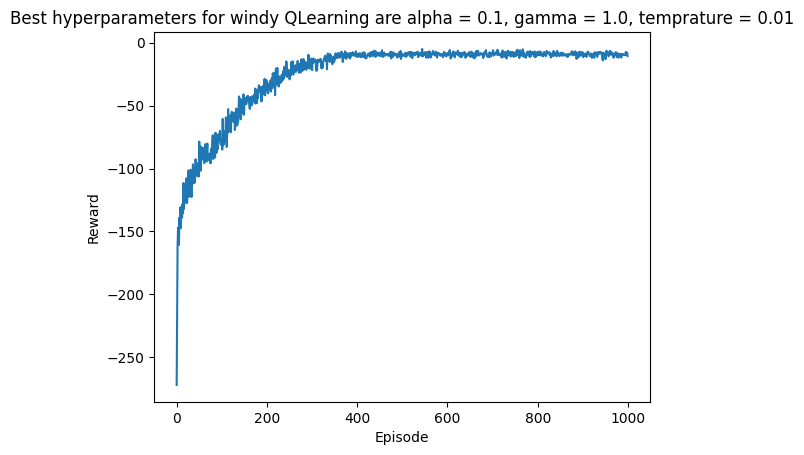

In [ ]:
plot_reward(rewards, title)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

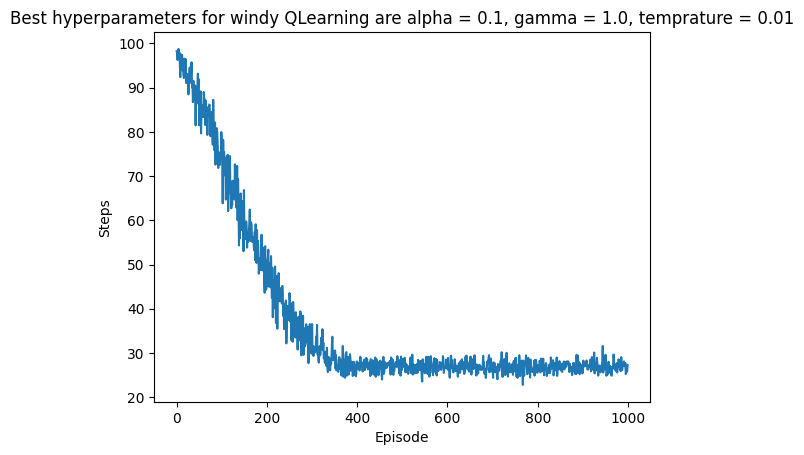

In [ ]:
plot_steps_to_goal(steps_to_goal, title)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

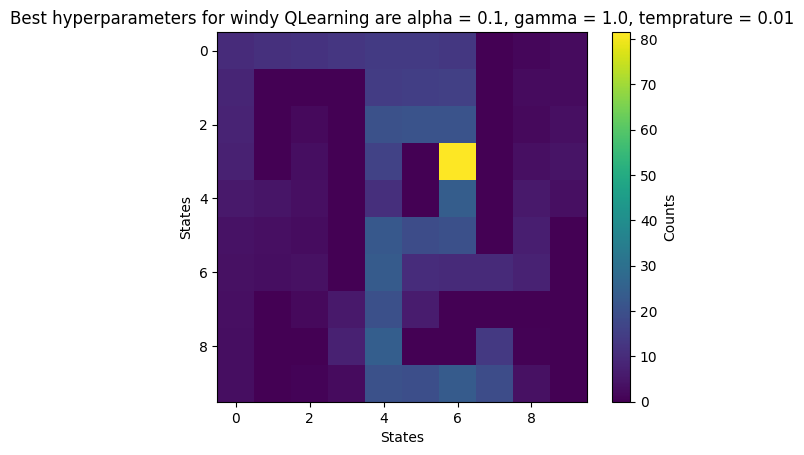

In [ ]:
plot_state_visit_counts(state_visit_counts, title)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

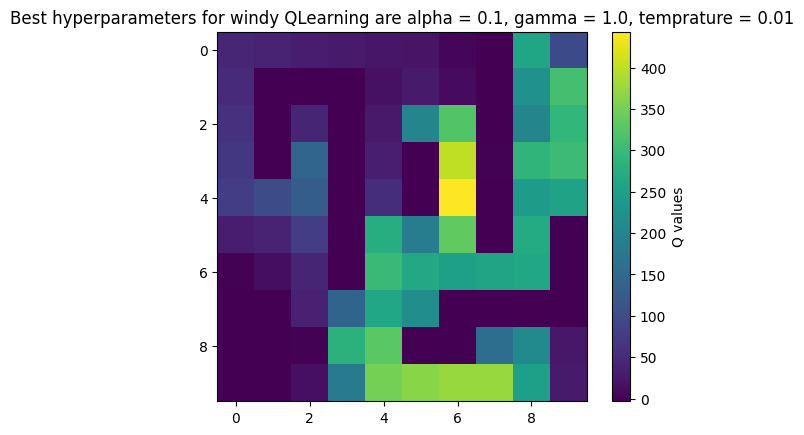

In [ ]:
visualize_policy(env, pi)
plot_q_values(env, q, title)

## Analysis

### SARSA

A written description of the policy learnt, explaining the behavior of the agent, and choice of hyperparameters.


The policy learned by SARSA in the Windy Gridworld accounts for the dynamic nature of the environment, specifically the wind's influence on the agent's movement. It balances exploration and exploitation to find an optimal or near-optimal strategy for reaching the goal state while considering both immediate and future rewards.

The SARSA hyperparameters are tuned to maximize the average reward across all 20 agents.

The most effective hyperparameters for the SARSA algorithm have been consistently identified through experimentation. Specifically, a learning rate (alpha) value of 0.1 has consistently demonstrated optimal performance across all 8 different configurations. This selection aligns with the understanding that a lower learning rate allows the agent to This selection aligns with the understanding that a lower learning rate allows the agent to make gradual and stable updates to its Q-values, facilitating a balanced exploration of the environment while ensuring convergence towards an effective policy.

Likewise, the most effective choice for the discount rate (gamma) consistently leans towards 1, though in certain windy configurations, a value of 0.9 has shown merit. This observation aligns with the inherent nature of the task, which is not continuous, thus emphasizing immediate rewards (gamma = 1) as a logical strategy for achieving optimal performance. However, in scenarios with strong wind dynamics, the agent may occasionally treat the task as more continuous in nature, hence the occasional preference for a slightly lower gamma value of 0.9.

In terms of the epsilon-greedy exploration strategy, a hyperparameter value of 0.001 has emerged as the most favorable. This signifies that the agent mostly exploits its current knowledge, with only occasional explorations, thus striking a balance between exploiting learned information and trying out new actions.

For the temperature parameter in the softmax action selection strategy, the optimal choice is 0.01. This implies that the agent generally leans towards choosing the most promising actions while occasionally considering alternatives based on their probabilities.

Overall, the consistent convergence of these hyperparameter values underscores their effectiveness and applicability in enhancing the SARSA algorithm's performance within this specific scenario.

In [ ]:

# Create a dictionary to hold the data
data = {'alpha': ['0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1'],
        'gamma': ['0.9', '1', '0.9', '1', '1', '1', '1', '1'],
        'epsilon': ['0.001', '0.001', None, None, '0.001', '0.001', None, None],
        'tao': [None, None, '0.01', '0.01', None, None, '0.01', '0.01']}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Set the index of the DataFrame
df.index = range(1, len(df) + 1)

# Fill missing values with empty strings
df = df.fillna('')

# Apply styling to the DataFrame
styled_df = df.style \
    .set_properties(**{'text-align': 'left'}) \
    .set_table_styles([{'selector': 'tr:hover',
                        'props': [('background-color', 'white'), ('color', 'black')], }]) \

# Display the styled DataFrame
styled_df


,alpha,gamma,epsilon,tao
1,0.1,0.9,0.001,
2,0.1,1,0.001,
3,0.1,0.9,,0.01
4,0.1,1,,0.01
5,0.1,1,0.001,
6,0.1,1,0.001,
7,0.1,1,,0.01
8,0.1,1,,0.01


Information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.


The behavior of the SARSA algorithm in the windy gridworld setting exhibits interesting variations when different factors are introduced, such as the presence of wind, and different start states.

When wind is present, the agent's movement is affected vertically, and alters its trajectory.  As a result the learned policy is sub optimal in some cases. In the absence of wind, the learned policy tends to optimize movements without the need to adjust for vertical displacements. The agent's behavior leads to quicker paths to the goal compared to the wind-affected scenario.

SARSA adapts its behavior based on the starting point in the gridworld. Depending on the initial state, the agent's learned policy prioritizes different paths and goes towards differnet goal states. In scenarios where the starting state is (0, 4), it's noteworthy that the rewards associated with reaching the goal states (2, 2) and (0, 9) are identical. Surprisingly, the agent consistently converges to an optimal policy for the goal state (2, 2). However, when the starting point shifts to (3, 6), where the rewards for reaching goal states (0, 9) and (8, 7) are also equal, the agent's behavior becomes contingent on the presence of wind. In the presence of wind, the agent exhibits a sub-optimal policy when striving for the goal state (0, 9). Remarkably, when the wind is absent, the agent effectively learns optimal policies for both (0, 9) and (8, 7) and appears to make an arbitrary choice between them.

In [ ]:

# Create a dictionary to hold the data
data = {'wind': ['True', 'False', 'True', 'False', 'True', 'False', 'True', 'False'],
        'p': ['1', '1', '1', '1', '1', '1', '1', '1'],
        'action selection': ['epsilon-greedy', 'epsilon-greedy', 'softmax', 'softmax', 'epsilon-greedy', 'epsilon-greedy', 'softmax', 'softmax'],
        'start state': [(0, 4), (0, 4), (0, 4), (0, 4), (3, 6), (3, 6), (3, 6), (3, 6)],
        'goal state' : [(2, 2), (2, 2), (2, 2), (2, 2), (0, 9), (0, 9), (0, 9), (8, 7)],
        'policy learnt' : ['optimal', 'optimal', 'optimal', 'optimal', 'sub-optimal', 'optimal', 'sub-optimal', 'optimal']}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Set the index of the DataFrame
df.index = range(1, len(df) + 1)

# Apply styling to the DataFrame
styled_df = df.style \
    .set_properties(**{'text-align': 'left'}) \
    .set_table_styles([{'selector': 'tr:hover',
                        'props': [('background-color', 'white'), ('color', 'black')], }]) \

# Display the styled DataFrame
styled_df


,wind,p,action selection,start state,goal state,policy learnt
1,True,1,epsilon-greedy,"(0, 4)","(2, 2)",optimal
2,False,1,epsilon-greedy,"(0, 4)","(2, 2)",optimal
3,True,1,softmax,"(0, 4)","(2, 2)",optimal
4,False,1,softmax,"(0, 4)","(2, 2)",optimal
5,True,1,epsilon-greedy,"(3, 6)","(0, 9)",sub-optimal
6,False,1,epsilon-greedy,"(3, 6)","(0, 9)",optimal
7,True,1,softmax,"(3, 6)","(0, 9)",sub-optimal
8,False,1,softmax,"(3, 6)","(8, 7)",optimal


### Q Learning

A written description of the policy learnt, explaining the behavior of the agent, and choice of hyperparameters.


The policy learned by Q-learning in a not windy gridworld emphasizes efficient navigation to reach the goal state while maximizing rewards. The agent balances exploration and exploitation, continually updating its Q-values to improve its decision-making process and ultimately converge to an optimal policy for the given environment. To reach the goal more quickly, the agent learns to avoid unnecessary backtracking and explores paths that lead toward the goal.

The QLearning hyperparameters are tuned to maximize the average reward across all 20 agents.

The most effective hyperparameters for the QLearning algorithm have been consistently identified through experimentation. Specifically, a learning rate (alpha) value of 0.1 has consistently demonstrated optimal performance across all 8 different configurations. This selection aligns with the understanding that a lower learning rate allows the agent to This selection aligns with the understanding that a lower learning rate allows the agent to make gradual and stable updates to its Q-values, facilitating a balanced exploration of the environment while ensuring convergence towards an effective policy.

Likewise, the most effective choice for the discount rate (gamma) consistently leans towards 1. This observation aligns with the inherent nature of the task, which is not continuous, thus emphasizing immediate rewards (gamma = 1) as a logical strategy for achieving optimal performance.

In terms of the epsilon-greedy exploration strategy, a hyperparameter value of 0.001 has emerged as the most favorable for start state (3, 6) & 0.01 for start state (0, 4). This signifies that the agent mostly exploits its current knowledge, with only occasional explorations, thus striking a balance between exploiting learned information and trying out new actions.

For the temperature parameter in the softmax action selection strategy, the optimal choice is 0.1 for start state (0, 4) and 0.01 for start state (3, 6). This implies that the agent generally leans towards choosing the most promising actions while occasionally considering alternatives based on their probabilities.

Overall, the consistent convergence of these hyperparameter values underscores their effectiveness and applicability in enhancing the QLearning algorithm's performance within this specific scenario.

In [ ]:

# Create a dictionary to hold the data
data = {'alpha': ['0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1'],
        'gamma': ['1', '1', '1', '1', '1', '1', '1', '1'],
        'epsilon': ['0.01', '0.01', None, None, '0.001', '0.001', None, None],
        'tao': [None, None, '0.1', '0.1', None, None, '0.01', '0.01']}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Set the index of the DataFrame
df.index = range(1, len(df) + 1)

# Fill missing values with empty strings
df = df.fillna('')

# Apply styling to the DataFrame
styled_df = df.style \
    .set_properties(**{'text-align': 'left'}) \
    .set_table_styles([{'selector': 'tr:hover',
                        'props': [('background-color', 'white'), ('color', 'black')], }]) \

# Display the styled DataFrame
styled_df


,alpha,gamma,epsilon,tao
1,0.1,1,0.01,
2,0.1,1,0.01,
3,0.1,1,,0.1
4,0.1,1,,0.1
5,0.1,1,0.001,
6,0.1,1,0.001,
7,0.1,1,,0.01
8,0.1,1,,0.01


Information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.


The agent's behavior changes considering different levels of stochasticity and start states in the context of Q-learning in a non-windy gridworld.


When there is stochasticity in the evnvironment, the agent's behavior becomes more exploratory & results in safer and more conservative movements. In a deterministic environment, the agent is more exploitative. The learned policy leans towards actions that have yielded higher rewards.

Qlearning adapts its behavior based on the starting point in the gridworld. Depending on the initial state, the agent's learned policy prioritizes different paths and goes towards differnet goal states. In scenarios where the starting state is (0, 4), it's noteworthy that the rewards associated with reaching the goal states (2, 2) and (0, 9) are identical. Surprisingly, the agent consistently converges to an optimal policy for the goal state (2, 2). However, when the starting point shifts to (3, 6), where the rewards for reaching goal states (0, 9) and (8, 7) are also equal, the agent effectively learns optimal policies for both (0, 9) and (8, 7) and appears to make an arbitrary choice between them.


In [ ]:

# Create a dictionary to hold the data
data = {'wind': ['False', 'False', 'False', 'False', 'False', 'False', 'False', 'False'],
        'p': ['1', '0.7', '1', '0.7', '1', '0.7', '1', '0.7'],
        'action selection': ['epsilon-greedy', 'epsilon-greedy', 'softmax', 'softmax', 'epsilon-greedy', 'epsilon-greedy', 'softmax', 'softmax'],
        'start state': [(0, 4), (0, 4), (0, 4), (0, 4), (3, 6), (3, 6), (3, 6), (3, 6)],
        'goal state' : [(2, 2), (2, 2), (2, 2), (2, 2), (8, 7), (8, 7), (0, 9), (0, 9)],
        'policy learnt' : ['optimal', 'optimal', 'optimal', 'optimal', 'optimal', 'optimal', 'optimal', 'optimal']}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Set the index of the DataFrame
df.index = range(1, len(df) + 1)

# Apply styling to the DataFrame
styled_df = df.style \
    .set_properties(**{'text-align': 'left'}) \
    .set_table_styles([{'selector': 'tr:hover',
                        'props': [('background-color', 'white'), ('color', 'black')], }]) \

# Display the styled DataFrame
styled_df


,wind,p,action selection,start state,goal state,policy learnt
1,False,1,epsilon-greedy,"(0, 4)","(2, 2)",optimal
2,False,0.7,epsilon-greedy,"(0, 4)","(2, 2)",optimal
3,False,1,softmax,"(0, 4)","(2, 2)",optimal
4,False,0.7,softmax,"(0, 4)","(2, 2)",optimal
5,False,1,epsilon-greedy,"(3, 6)","(8, 7)",optimal
6,False,0.7,epsilon-greedy,"(3, 6)","(8, 7)",optimal
7,False,1,softmax,"(3, 6)","(0, 9)",optimal
8,False,0.7,softmax,"(3, 6)","(0, 9)",optimal
